# What are the common activities that the victims were engaged in prior to the accident?

In [256]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter
import csv

# List Of Category indexes as per stated in the CA document

In [257]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [258]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [259]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # Note MsiaCases only summary case but Osha has description
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column, 
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Description'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [260]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def VisualisationAll(SelectedCases):   
    tokens_clean_single = []
    for item in SelectedCases:
        if (len(item.ActivityTokensVerb)>0):
            # frequecy distribution chart
            for tok1 in item.ActivityTokensVerb:
                tokens_clean_single.append(tok1)
    fd = nltk.FreqDist(tokens_clean_single)
    fd.most_common(25)
    TopActivityTokens = fd.most_common(5)
    fd.plot(25)
    print("Total count for this dataset is " + str(len(tokens_clean_single)))
    #print(tokens_clean_single)
    #print(TopActivityTokens)

    # ==== Installation of wordcloud package
    # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
    # 2. Copy the file to your current working directory
    # 3. Open command prompt from Tools
    # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl

    # 1. Simple cloud
    # Generate a word cloud image
    # Take note that this function requires text string as input
    # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
    wc = WordCloud(background_color="white")
    wc.generate_from_frequencies(fd)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()    
    print("\n")

In [261]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(5)
        fd.plot(25)
        print("Total count for this category is " + str(len(tokens_clean_single)))
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(fd)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()            
        with open('summary.csv','a') as file:            
            file.write(category.Name + "," + str(len(tokens_clean_single)) + "," + str(list(fd.most_common(5))) + "\n")
            
    else:
        print("Visualisation Function : No activity verb data available")        
    if (len(category.ActivityTokensChunk)>0):
        chunks_limit = 10
        print("Top 5 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : No activity chunk data available")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [262]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have', 'wear', 'use', 'work', 'exist', 'remain', 'include', 'experience','come','contain','ensue','crush','miss','receive']
    filter_all_words = ['carry out work', 'fly object']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['kill','carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in ' '.join(get_lemma(untag(subtree))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in ' '.join(get_lemma(untag(subtree))) ):
            print (faw)
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [263]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """

    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [264]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [265]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = True
ProcessOshaDataSet = False

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [266]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

installing wood plate(1)
carrying the job of binding Reinforcement Steel Cage(2)
climbing up the cage(1)
performing cable pulling job(2)
opening the clutch door(1)
dismantling Shear Wall(1)
carry out work
controlling the traffic(1)
entering the room(1)
move the box containing foods(1)
moving forklift(1)
carrying mold installation(1)
stepping on the hollow section(1)
replacing the bricks(1)
wrapping plastic tubing(2)
breaking the stone(1)
lying on the floor(1)
cutting down trees(1)
lifting a bundle(1)
cutting down trees(1)
lifting a pile(1)
lift the lifting tray(1)
removing the glass door(1)
tagging the name(1)
standing on plywood plate(1)
carry out binding(1)
lifting lug(1)
lifting works using Overhead Travelling Crane(3)
cutting the oil palm fruit(1)
knitting the oil palm fruits(1)
driving mechanical buffalo(1)
dismantling the top structure(1)
climbing the scaffolding(2)
driving downhill(1)
standing on the drawbar trailer(1)
lifting the drain block(1)
carrying road leveling work using

In [254]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

operating a forklift(1)
moving bales(1)
replacing an air filter(1)
specializing in fiber(1)
marking the location(1)
performing the duties(1)
travelling in the travel/through lane(1)
offloading hot brine water(1)
switching the truck(1)
let go causing the hot brine water(1)
running toward the control room(1)
transferring soup(1)
cutting the seal(1)
pulling a knife(1)
placing on the knife(1)
stabbing type(1)
operating a rough terrain forklift(1)
positioning the forklift(1)
pulling a cart(1)
making turns(1)
turning cart(1)
installing vinyl sidings(1)
standing an A-frame ladder(1)
Using the table(1)
ripping the piece(1)
ripping the second board Employee(1)
cutting a third piece(1)
alleging violation(1)
ripping pieces(1)
transferring product(1)
operating an asphalt-pulverizing machine(2)
cleaning the interior(1)
standing in front(1)
inspecting the 21000-volt pad(1)
idling Caterpillar D8K track bulldozer(1)
lowering the unit(1)
kneeling on the bulldozer(1)
insert nails into roofing tiles(1)
w

removing the old tile(1)
removing old adhesive(1)
scrubbing the floor(1)
removing safety brackets(1)
supporting the trellis(1)
connecting the trellis(1)
connecting the trellis(1)
cutting a pipe(1)
cutting the well(1)
casing igniting an unknown substance(2)
cutting the well casing(2)
welding gloves(1)
break the concrete lining(1)
separating the pipe(1)
sling hooks(1)
sustaining severe injuries(1)
removing the roof(1)
cutting torch(1)
sorting out different types(1)
turning on the acetylene(1)
adjusting the torch(1)
connecting the hose(1)
cutting torch(1)
burning both men(1)
cutting torch(1)
lowering the lift(1)
utilizing an oxygen-acetylene torch(1)
utilizing the torch(1)
sitting on the opposite front tire(1)
holding a piece(1)
entering the engine(1)
cutting torch(1)
watching out for any fires(1)
standing in front(1)
servicing tractor discs(1)
cutting tip(1)
catching the acetylene lead(1)
welding a new section into the existing pipeline(2)
standing in an excavation(1)
sitting in the exca

operating a Taurus CNC machine(1)
running a program(1)
removing the carbon dust(1)
rotating bit(1)
exsanguinating intra-abdominal hemorrhage(1)
unloading a trailer(1)
contributing causal factor(1)
handling facility(1)
repairing a leak(1)
pruning the tops(1)
telescoping in a design(1)
remove the jammed material from the pruning head(1)
amputating the tip(1)
disassembling the facility(1)
holding this unit(1)
performing a brake work on paving truck Number(2)
replacing the first air line(1)
ringing in both ears(1)
inflating a tire(1)
releasing chlorine(1)
leaving the plant(1)
breathing air(1)
attaching the airlines(1)
specializing in building docks(2)
installing fender panels(1)
protruding portion(1)
striking the water(1)
sandblasting a precast panel(1)
carrying the liquid coolant(1)
diving operations(1)
turning under the torque(1)
overseeing the job(1)
communicating on the headset(1)
monitoring the breathing air(2)
breathing air(1)
sandblasting stainless steel(1)
sandblasting stainless st

backing up the milling machine(2)
driving lane(1)
back the milling machine(1)
passing lane(1)
transiting the facility(1)
walking across the new roadway(1)
paving machine(1)
operating a New Holland(1)
traveling in reverse(1)
standing in the path(1)
spraying water(1)
opening the nozzle bale(1)
performing landscape maintenance(1)
operating a weed-eater(1)
driving under the influence(1)
landing coming down the marble stairs(2)
staying at the hotel(1)
jumping from the front(1)
utilizing a high-pressure water hose(1)
loading tobacco(1)
drinking beer(1)
directing traffic(1)
lighting traffic signs(1)
traveling southbound(1)
programming the transmitters(1)
treating inmates(1)
tipping the drum(1)
spilling alcohol(1)
grinding a small metal disk(1)
spilling the alcohol(1)
grinding in a direction(1)
running the grinder(1)
cleaning with a rag(1)
drinking alcohol(1)
sleeping on a couch(1)
fighting the fire using hand(2)
hitting the ledge(1)
separating the glass(1)
separating the glass(1)
following th

erecting a grain leg(1)
adjusting the come-a-long in a forward motion(1)
paving company(1)
relocating a guy(1)
sustaining entry wounds(1)
installing roof decking(2)
allowing the employee(1)
moving logs(1)
gripping at the hoist(1)
standing inside the bight(1)
installing wire mesh(1)
installing lathing(2)
sitting down on the floor(1)
operating a Makita(1)
setting up chairs(1)
grading foreman(1)
watering various trees(1)
sustaining an aneurysm(1)
lying beside a concrete mixer truck(1)
attending physician(1)
arriving at the scene Employee(1)
suffering a heart attack(1)
performing routine checks(1)
leading from the tank(1)
leaking ammonia(1)
repositioning an adjustable scaffold(1)
releasing ammonia vapors(1)
removing an anhydrous ammonia tank(1)
standing behind Employee(1)
entering the corridor Employee(1)
filling a nurse tank(1)
lying on the ground(1)
disconnecting the hose(1)
filling the nurse tank Employee(1)
hooking the tank(1)
expanding boiling-liquid blast(1)
replacing a solenoid valv

removing the plastic containment material(1)
removing plastic(1)
removing plastic(1)
helping a coworker install(1)
scaffolding on the inside(1)
removing asbestos(1)
removing the old roof(1)
unscrewing the bolts(1)
laboring for Ontario Specialty Contracting Inc.(2)
renovating the lobby(1)
surfacing material(1)
surfacing material(1)
surfacing material(1)
mixing a water/bleach solution(1)
performing asbestos removal(1)
standing on a metal ventilation duct(1)
reaching toward the wall(1)
performing this type(1)
wet down the asbestos-containing ceiling drywall boards(2)
break down the ceiling material(1)
performing the removal(1)
performing the breakdown(1)
driving the scraper(1)
testing during the inspection(2)
performing all maintenance(1)
tuning the engines(1)
sitting on top(1)
removing asbestos(1)
rolling scaffold(1)
sustaining a small laceration(1)
hitting a piece(1)
removing asbestos(1)
removing asbestos(1)
clearing access(1)
standing at the base(1)
tearing down the brick doors(1)
sett

completing the cleaning(2)
standing on the ground(1)
holding the auger(1)
operating a Premier Model(1)
leaving the wrench(1)
mounting the cab(1)
walking in front(1)
standing in front(1)
cleaning snow off the top(1)
removing the throat part(1)
moving auger(1)
severing the tip(1)
servicing a beverage machine(1)
cutting action(1)
spraying a fire retardant(1)
dumping the fire(1)
pushing some of the material(1)
sanitizing a dough mixer(1)
sanitizing the dough mixer(1)
entering the dough mixer(1)
taping the plastic cover(1)
ring fingers(1)
unclogging the Pomace Incline Conveyor line(1)
clearing a jam(1)
cleaning a meat tenderizer machine(1)
ring fingers(1)
disconnecting the cord(1)
performing sanitation activities(1)
slicing line(1)
cutting product process(1)
slicing machine(1)
shut down the process line for cutting paper(1)
putting bacon(1)
setting up operations(1)
placing the left gear(1)
ring finger(1)
folding a carton plant(1)
setting up operations(1)
moving components(1)
repairing the p

grasping for air(1)
suffering from fatal injuries(1)
loading dock(1)
exposing employer(1)
creating employer(1)
digging dirt(1)
backing up a dump truck(1)
traveling in reverse 3-5 miles(1)
functioning back alarm(1)
moving backwards(1)
walking on the grounds(1)
harvesting peaches(1)
unloading pallets(1)
shipping doors(1)
bring the dock stopper(1)
changing direction(1)
reversing forklift(1)
driving a garbage truck(1)
recycling company(1)
recycling company(1)
wrecking truck company(1)
standing on the right rear side(1)
directing the wrecker(1)
loading mechanism(1)
watching Employee(1)
tying down a tarp(1)
moving a bob cat(1)
loading dock(1)
loading dock area(1)
walking down the catwalk(1)
handling system(1)
handling system(1)
repairing the conveyor(1)
bagging feed corn(1)
standing against the bagging machine(2)
leaving Gate Number(1)
finishing the job of loading baggage(2)
standing on a passenger seat(1)
inspecting moving parts(2)
steering wheel(1)
serving as a crew leader(1)
off-loading i

connecting the cross-aisle cable(1)
ring fingers(1)
requiring surgeries(1)
changing an electric forklift battery(1)
providing supplies(1)
maintaining the entire fleet(1)
asking for a new battery cable(1)
noticing that the middle battery(1)
welding a nickel tab(1)
welding the battery(1)
repairing the wiring harness(2)
extinguishing the fire(1)
lighting strike(1)
cutting torch(1)
connecting piping a metal stairway(2)
operating an overhead gantry hoist crane(1)
charging station(1)
lifting a battery(1)
lifting beam(1)
slipping out of the battery eyelet(1)
unplugging a 480-volt drop cord(1)
unplugging the cord(1)
charging a forklift battery(1)
ejecting acid(1)
riding pallet jack(1)
riding pallet jack(1)
pinning Employee(1)
charging station(1)
driving a stand-up electric forklift(1)
charging unit(1)
leaning against an air compressor tank(1)
installing equipment(1)
leaning on a live battery charger(1)
charging the batteries(1)
flying pieces(1)
starting the ignition(1)
starting the buses(1)
st

operating the air valve(1)
climbing from a ladder(1)
operating a bladder-type forming machine(2)
loading paper rolls(1)
installing a new bathroom countertop(1)
cutting the sink hole(1)
standing facing the jointer(2)
functioning at the time(1)
moving blade(1)
clearing a jam(1)
rotating blades(1)
shaping a bush(1)
facing the bush(1)
shearing action(1)
repairing railroad freight car load dividers(1)
standing on the bulkhead(1)
pinning Employee(1)
driving a high-lift forklift truck(1)
lowering a chain(1)
lowering the chain(1)
running Employee(1)
hanging from the forks(1)
controlling levers(1)
pinning Employee(1)
demonstrating the proper removal(1)
descending the tree(1)
warning the employee(1)
waiting for the ambulance(1)
testing the integrity(1)
installing concrete traffic barriers(1)
setting K-rails(1)
operating a National crane Model N-135(1)
overloading the crane(1)
advancing the stock(1)
rotating blade(1)
grinding a food product(1)
turning the machine(1)
sealing surface(1)
moving blad

cutting the straps Employee(1)
transferring a product(1)
transferring the product(1)
clean out the docking leveres(1)
lifting the docking lever plate(2)
placing the prop(1)
striking Employee(1)
setting the prop(1)
sanding a cabin door(1)
floating dock housing(2)
making a delivery(1)
operating a tug(1)
suffering a broken neck(1)
operating a Shuttlewagon SWX415B(1)
moving railcar(1)
handing out small recreational boats(1)
signaling the crane(1)
fabricating a new dredge boat(1)
painting inside the first pontoon compartment(1)
nearing completion(1)
painting this compartment(1)
dismantling a scaffold(1)
rigging cable using test(2)
striking Employee(1)
driving a customer(1)
travelling at wide open throttle the boat(1)
inspecting a piece(1)
reinstalling a metal(1)
welding vapors(1)
rotating spindle(1)
rotating the spindle(1)
unwinding the yarn onto the rotating metal(2)
roving machine(1)
standing at a wire rope(1)
cutting torch(1)
repairing the leak(1)
cleaning up the leaking oil(2)
cleaning 

descending the tree(1)
climbing rope(1)
climbing saddle(1)
driving a Ford F550(1)
depending on the size(1)
rolling down the sloped deflection plate(1)
turning the large boulder(1)
installing a drainage system(1)
operating a double-roller(1)
remove a large stuck boulder between operating conveyor belt(1)
digging holes(1)
facing a dam(1)
removing a boulder(1)
fighting a blaze(1)
supervising the installation(1)
shoring along the south wall(1)
protruding rock(1)
protruding rock(1)
shoring support system(1)
rolling down from a spur road(1)
breaking the rock(1)
standing on an adjacent boulder(1)
standing on the trail(1)
laying a French drain(1)
digging a hole(1)
clearing trails(1)
waiting for the cast skidder(1)
preparing a road bed(1)
replacing the parts(1)
cleaning the equipment(1)
setting machine(1)
tagging out the equipment(1)
setting bed(1)
setting bed(1)
clearing a jam(1)
bowling pin machinery(1)
cutting across the Employee(1)
operating a rotary slitter/scorer machine(1)
rolling the fu

laying bricks(1)
running the block cuber/stripper machine(1)
catching Employee(1)
setting machine(1)
operating a brick cutter(1)
lying under the brick cutter(1)
rotating hydraulic arm(1)
operating the setting machine(2)
cleaning out pieces(1)
lying on the table(1)
setting the machine(1)
fool the machine by hanging weights(1)
performing this procedure(1)
catching Employee(1)
operating machine(1)
guarding devices(1)
looking in the direction(1)
operating a DitchWitch SK350 rubber(1)
standing on the skid steer(1)
pouring concrete(1)
making preparations(1)
securing the area(1)
lying unresponsive on the catch net(1)
lighting during shotcrete application(2)
backing up the track(1)
instaling a metal chanel(1)
suffering from multiple injuries(1)
rigging for tarps(1)
moving a 36-foot guardrail section(1)
covering several acres(1)
removing pieces(1)
standing on a work platform(1)
operating a bridge crane(1)
removing tension(1)
standing on the steel plate(1)
placing a plywood screen(1)
placing bri

feeding a brush chipper(1)
feeding a branch(1)
feeding bay(1)
cleaning up around the mill(1)
open the cutter wheel housing(1)
cleaning a drive system(1)
clearing brush(1)
operating a loader-backhoe(1)
clearing a path(1)
trimming brush(1)
hearing a sound(1)
cutting down thick grass(1)
riding lawn mower(1)
pulling the brush hog(1)
pulling the brush hog(1)
operating a tree chipper(1)
feeding landscape clearing materials(2)
chipping trees(1)
standing on the feed tray pushing brush(2)
feeding brush(1)
placing tree limbs(1)
trimming trees(1)
feeding brush(1)
cutting a limb(1)
cutting the limb(1)
cutting clean through the stalling(2)
holding wood(1)
swing down in an arc(1)
operating a Morbark Hurricane wood chipper(1)
reverse the feeding wheel(1)
supervising women(1)
cutting brush(1)
Following the second set(1)
providing directions(1)
sawing brush(1)
operating the chain(1)
trimming trees(1)
feeding a freshly cut eucalyptus(1)
adjusting the chipper(1)
feeding a large tree limb(1)
clearing the 

installing electrical equipment(1)
guiding electrical wire(1)
installing the switch gear(1)
specializing in electrical installation(1)
following a customer(1)
move as closing(1)
parking brake safety feature(1)
raising the truck(1)
supporting the truck(1)
lowering vehicle(1)
raising rear suspension components(1)
driving a Wolfline bus(1)
tapping down the amperage(1)
removing locking pins(2)
locking pin(1)
locking pin(1)
locking pin(1)
plowing around the bus building(2)
lying face(1)
facing toward the interior(1)
securing the bus(1)
removing a bottle jack(1)
transiting across the parking lot(2)
pulling into the parking lot(2)
raining throughout the day(1)
descending industrial stairs(1)
walking in the parking lot(2)
walking in the parking lot Employee(2)
replacing a leaf spring(2)
bushing on a school bus(1)
inserting a pin(1)
preventing the pin(1)
assisting in the separation(1)
connecting the vehicle body(1)
Using a Caterpillar loader Model Number(1)
hindering the separation(1)
striking 

connecting the wire(1)
checking a capacitor(1)
servicing an air handler unit(1)
reexamining the inside(1)
consulting engineer(1)
inspecting Capacitor Bank Number(1)
putting out the fire(1)
calling emergency services(1)
testing capacitor-coupled transformers(1)
changing a capacitor(1)
troubleshooting a capacitor bank(1)
switching signals(1)
replacing a 120-volt single-phase dual-capacitor(1)
installing a jumper(1)
touching a grounded metal chassis(1)
servicing a sump pump(1)
placing the cover(1)
touching the housing(2)
installing a 120-volt squirrel-cage fan(1)
reconnecting the first phase conductor(1)
testing following a fault(2)
testing equipment(1)
troubleshooting a commercial microwave(1)
performing this job(1)
tagging program(1)
troubleshooting an air conditioner(1)
Kneeling on damp ground(1)
resting against the grounded case(1)
burning smell(1)
utilizing equipment(1)
removing outside man-way covers(1)
entering the freezer unit(1)
assist believing that Employee(1)
testing over seve

operating this particular core blower press Employee(1)
operating the press(1)
reaching into the point(1)
conditioning unit(1)
support a casting(1)
cutting torch(1)
remove casting supports(1)
contributing factors(1)
ring fingers(1)
holding a cylindrical-shaped aluminum part(1)
activating the machine(1)
casting shop(1)
conducting a production run(1)
operating a manually-fed job(1)
cutting machine(1)
cutting machine(1)
positioning the die(1)
standing on the right side(1)
standing on the left side(1)
moving platen(1)
moving platen(1)
trapping the upper left torso(1)
placing the die(1)
contributing factors(1)
closing on employees(1)
changing the lot number strip(1)
operating a pressure transmission die(1)
interlocking limit switch(1)
crawling up underneath the south bell slide cylinder rod(1)
interlocking limit switch(1)
operating a Lester Company cold-chamber die casting machine Serial Number(2)
casting machinery(1)
pouring molten aluminum(1)
sliding barrier gate(1)
exhibiting problems(1)

climbing up the ladder(1)
pour a concrete footing(1)
digging this trench(1)
conducting a top/surface cementing job(2)
pumping the cement(1)
installing a concrete walkway(1)
leaning over the edge(1)
railing broke(1)
lining a section(1)
stripping the forms(1)
watching the pumping(2)
striking Employee(1)
installing a fixed swimming pool(2)
setting the concrete stairs(1)
mixing the concrete(1)
ring finger(1)
finishing the cement(1)
protruding from the poured concrete(1)
protruding piece(1)
installing of a wire rope(1)
landing platform(1)
rigging system(1)
tensioning the main wire rope(1)
tensioning the wire rope(1)
draw the rigging(1)
removing wall plates(1)
tightening equipment(1)
touching the chain(1)
operating a chainsaw(1)
bucking a log(1)
removing an iron fence roll(1)
operating the machine(1)
weaving machine(1)
running on a 240-volt AC power supply(1)
disconnecting the rigging chains(2)
unbolting the eye bolts(1)
removing the nut(1)
retrieving a box(1)
drilling a well(1)
operating a 

holding tanks(1)
forming a vapor cloud(1)
coughing while in the course(1)
cleaning the butcher block area(1)
mixing a chlorine slurry by adding chlorine granules(2)
mixing the slurry(1)
removing the roof(1)
contributing factor(1)
taking the employee(1)
conducting a start-up(1)
assisting the tractor operator in adding chlorine(2)
scratching the area(1)
generating system(1)
sorting area(1)
emitting from the belt(1)
conveying the tomatoes(1)
generating system(1)
installing reinforcement bands(1)
entering an unknown released concentration(1)
spraying the Picking Room(2)
breathing zone(1)
stopping the leak(1)
notifying management(1)
requiring hospitalization(1)
meeting with the WTPO(1)
heading toward the chlorine room(1)
taking water samples(1)
serving an industrial park(1)
repairing the transmission(1)
ProTowing the owner(1)
towing company(1)
loading dock(1)
stopping CPR(1)
changing out the left landing leg drive leg(2)
holding the landing legs(2)
landing leg(1)
adjusting the brakes(1)
all

getting products(1)
climbing down from a unit(1)
climbing tower(1)
instruct students on safe climbing techniques(1)
waiting on the ground(1)
installing cable(1)
climbing gaffs(1)
climbing belt(1)
placing the belt(1)
climbing gaff(1)
maintaining the climbing gaffs(2)
performing a pole climbing exercise(2)
replacing a pair(1)
climbing a pole(1)
climbing the pole using gaffs(2)
completing the connection(1)
climbing down the ladder(1)
forming climbing profiles(2)
climbing sequence(1)
hoisting a series(1)
carrying a rope(1)
performing an annual evaluation test(1)
climbing a telephone pole(1)
replacing an old power pole(1)
rigging on the old pole(1)
holding the old pole(1)
driving a forklift(1)
climbing steel racks containing pallets(2)
placing hold tags(1)
operating a forklift truck(1)
operating a sealer(1)
allowing the machine(1)
pushing buttons(1)
setting up a label making machine(2)
rotating coil(1)
clearing a clogging(2)
operating a Lummus lint cleaner(1)
Following the surgical procedur

framing with an electric drill Milwaukee Cat(1)
servicing a roof-mounted evaporative cooling system(2)
climbing a ladder(1)
descending a ladder(1)
fracturing several ribs vertebrae(1)
loading broken bales(1)
standing on the bed(1)
sheathing at the edge(1)
framing a carport(1)
extending wood blocks(1)
holding a cable tray(1)
providing appropriate fall protection(1)
lifting a board(1)
leading edges(1)
assisting a field(1)
removing a positive displacement pump(1)
locating wires(1)
operating a Kubota mule(1)
steering wheel(1)
parking brake(1)
getting out of the Kubota(1)
installing/repairing a TV satellite system(1)
utilizing personal fall protection(1)
installing a steel sheet metal box header(1)
standing on the fifth rung(1)
getting the box(1)
moving pallets(1)
observing a volleyball game(1)
attending school(1)
sitting at midcourt(1)
observing the varsity game(1)
sitting in the home bleachers(1)
moving ingredients(1)
approaching the metal rack driving(2)
assisting a disabled vehicle(1)
s

filling a 60-cylinder manifold system(1)
filling a gas cylinder(1)
turning off the cylinder valves(1)
moving oxygen cylinders(1)
traveling down a ramp(1)
piping systems(1)
catching fire(1)
holding the valve(1)
refueling station(1)
catching Employee(1)
refueling station lot(1)
turning the propane(1)
filling a tank(1)
emptying halon(1)
installing a pressure regulator(1)
transporting a container(1)
investigating the accident(1)
lighting the heater(1)
filling a diving cylinder(2)
picking up the cylinder(1)
connecting the oxygen filling hose(2)
shearing scrap metal(1)
shearing jaws(1)
cleaning the threads(1)
punching holes(1)
punching a hole(1)
striking Employee(1)
burning the Production Supervisor(1)
hitting the fan(1)
diagnosing an oil leak(1)
compressing a vehicle strut(1)
holding a pipe extension(1)
pulling the entire piece(1)
arcing in the outdoor(1)
disconnecting high pressure line(1)
deenergizing the unit(1)
touching the belt(1)
Staffing the primary employer(1)
emptying by hand(1)
Lo

pouring concrete(1)
Building A(1)
finishing the concrete floor(1)
tying the hose(1)
performing the duties(1)
moving slabs(1)
restraining a granite slab(1)
operating the forklift(1)
employing company(1)
applying slight pressure(1)
create a door opening(1)
moving this contraption Employee(1)
pulling on the yellow strap(1)
pulling this mobile cherry picker(1)
creating an opening(2)
cutting concrete pavers(1)
sitting on a concrete slab(1)
catering truck(1)
assisting with the erection(1)
assisting the lead carpenters(1)
sliding the third level(1)
flooring overhead onto the adjacent forklift(1)
leading edge(1)
recovering in the hospital(1)
cutting rebar(1)
cutting the rebar(1)
stripping some wire(1)
walking on a grassy median towards(1)
applying roof sealant(1)
climbing a fixed ladder(1)
climbing the ladder(1)
pouring a concrete slab(1)
feeling ill(1)
walking toward the truck(1)
operating the forklift(1)
riding the lift truck(1)
dropping the concrete pipe(1)
approaching the warehouse(1)
sust

sitting on the hot griddle(1)
cleaning a tortilla press(1)
cleaning the top plate(1)
heating plates(1)
allowing Employee(1)
cooking oil(1)
going down the stairs(1)
carrying an open deep fryer(1)
assessing the extent(1)
excruciating pain(1)
hyperventilating upon arrival(1)
standing in front(1)
dislocating Employee(1)
spewing oil(1)
cleaning a metal tray(1)
requiring a skin graft(1)
grilling outdoors(1)
replacing the high limit sensor(1)
changing hot frying oil(2)
draining the oil(1)
cleaning braising pan No(2)
cleaning a large cooking pot(2)
drain the used cleaning water(1)
cooking mixing(2)
cooking/processing lines(1)
cooking ingredients(1)
getting full with product(1)
disassembling the transfer pipe(1)
preparing food(1)
closing the restaurant(1)
cleaning all equipment(1)
carrying out the restaurant(1)
filtering the hot oil(1)
cleaning the equipment(1)
kneeling on the grill(1)
reporting the injury(1)
signaling that the cook cycle(1)
releasing steam(1)
pressing down on the metal plate(1

operating a manlift(1)
operating the left car(1)
standing on the outside(1)
operating the right car(1)
knowing that Employee(1)
creating slack(1)
smashing a structural member(1)
supplying power(1)
exiting an elevator(1)
loosening the second counterweight(1)
assisting in the operation(1)
releasing the gantry crane(1)
striking Employee(1)
bring the car(1)
perform skin grafting(1)
setting up the ratchet(1)
leaving the hospital Employee(1)
opening the woodshop(1)
going into the housing(2)
enter the housing(1)
ring Employee(1)
standing on top(1)
lying on the ground(1)
lying on the ground(1)
repairing the cover(1)
striking the ground(1)
Depending on the depth(1)
connecting the components(1)
walking across the school campus(1)
walking the employee(1)
gathering information taking measurements(2)
reviewing existing conditions(2)
conflicting testimony(1)
covering a floor opening(2)
covering the opening(2)
removing the plywood(1)
violating company safety rules(1)
creating the hazard(1)
roofing op

directing the unloading(2)
operating the shore side Crane number(1)
operating a 35-ton capacity rough terrain crane(1)
swinging the load(1)
driving a REDI-LIFT Hydraulic truck crane(1)
delivering a concrete box(1)
positioning truck(1)
tearing down phone lines(1)
operating a pendant(1)
cooling racks(1)
galvanizing tanks(1)
cooling stands(1)
galvanizing area(1)
cooling rack(1)
raising the crane(1)
operating the pendant control(1)
assembling a rig derrick(1)
standing on the operator(1)
maneuvering the boom(1)
parking lot(1)
operating a 225-ton American Crawler Crane(1)
pinning Employee(1)
removing scrap metal(1)
hitting the cab(1)
driving the metal cage(1)
inserting the sling(2)
performing the reroofing(2)
removing a stack(1)
staging equipment(1)
hearing trees(1)
seeing the boom(1)
operating a P(1)
dismantling the crane(1)
rigging onto another flatbed(1)
starting this job(1)
swing the crane(1)
starting the task underway(1)
following the accident(1)
awaiting surgery(1)
extending past the e

switching the hydraulic hose configuration(1)
cutting zip ties(1)
supporting a jaw crusher(1)
replacing a worn toggle plate(1)
glancing blow(1)
standing in front(1)
striking Employee(1)
lowering a 37-ft rock conveyor(1)
assess the locking arms(1)
locking arm(1)
operating a jaw crusher(1)
breaking in the crusher(1)
unclogging a Follett Symphony-series ice machine(1)
Using a deli slicer(1)
slicing cheese at a slicing table(2)
touching the slicer(1)
holding the drop(1)
digging a receiving pit(2)
insulating gloves(1)
investigating an incident(1)
cleaning a large fuel oil storage tank(1)
facilitate the cleaning(1)
welding plug(1)
unplugging the welding plug(2)
cleaning the interior(1)
pulling the light(1)
repairing a power utility(1)
waiting for the feeder line(1)
insulating blanket(1)
insulating arm protector(1)
repairing a 7200-volt overhead power line(1)
insulating sleeves(1)
moving the cutout(1)
pulling a cut lever(1)
mowing grass(1)
mowing near a ditch(1)
pushing the mower(1)
running b

installing a new sprinkler head(1)
rolling scaffold(1)
measuring the ceiling(2)
rolling scaffold(1)
cleaning at the base(1)
installing a 24-foot railing(2)
specializing in the design(1)
framing a two-story house(1)
finding Employee(1)
standing with both heels(1)
dropping from the first floor(1)
placing tools(1)
installing the initial roof decking(2)
decking from the second floor(1)
spreading metal(1)
decking on the second floor(1)
laying decking on the roof(2)
landing face(1)
giving verbal directions(1)
correctly position roof decking bundle(1)
assisting in the roof(1)
decking bundle placement(1)
building an outside wood deck(1)
injuring Employees(1)
placing deck sheets(1)
opening with a total depth(1)
decking zone(1)
sliding the sheets(1)
Sliding the deck sheets(1)
arriving at the edge(1)
leading edge(1)
holding the end(1)
erecting structural steel(1)
rigging striking Employee(2)
installing steel(1)
sheeting at a Kohl(1)
welding person(1)
weld the sheeting(1)
moving a sheet(1)
creatin

Contributing causal factors(1)
descending a fixed metal ladder(1)
taking the coowner(1)
descending the wood ladder(1)
performing a stunt(1)
occurring with the detergent(1)
Packaging Utility Sanitation(1)
taste anything(1)
interviewing the employer(1)
awaiting permission(1)
cleaning a mixing vessel(2)
unpacking small detonators(1)
deslagging the boiler(1)
wounding Employee(1)
picking up the empty boxes(1)
handling electric detonators(1)
assisting in preparations(1)
simulating a collision(1)
excavating a hole(1)
injuring both employees(1)
setting blasting charges(2)
putting the detonator cord(1)
operating a Johnson(1)
running blank-out copper cans(1)
sitting in a forklift truck(1)
positioning the upper portion(1)
assisting the employee(1)
operating a punch press(1)
saying that the employee(1)
operating a handle(1)
press the backing(1)
approaching the ram(1)
reducing the diameter(1)
preventing the end(1)
Staffing a temporary staffing agency(2)
operating a punch press(1)
jogging the feeder

plating tanks(1)
varying compounds(1)
feeling for flow(1)
flashing light horn(1)
provide personal protective equipment including safety glasses(1)
Prohibiting Use(1)
emptying trash receptacles(1)
lifting mechanism(1)
clamping device(1)
picking up garbage(1)
clamping device(1)
covering striking Employee(2)
holding a valve(1)
plugging in the electrical cord(1)
lying on the table(1)
turning off a main disconnect switch(1)
traveling block(1)
Following the completion(1)
disconnecting the power(1)
disassembling a section(1)
removing boom section(1)
dissembling a crane boom(1)
cleaning out a concrete hopper(1)
entering the hopper(1)
performing normal maintenance procedures(1)
removing old concrete(1)
start the metering belt(1)
rotating blending paddle(2)
installing a new elevator car(1)
hanging from a 6-ft step(1)
depressing the stop button(1)
lying in a prone position(1)
operating a Townsend(1)
living in a firefighters(1)
conducting a study(1)
performing these activities(1)
trapping equipmen

transferring an elevator door(1)
sliding the door(1)
walking into an elevator(1)
pulling the forklift(1)
reaching through an electric entrance gate(1)
troubleshooting problems(1)
pending further evaluation(1)
cleaning around the top(1)
picking up a load(1)
stabilizing bar(1)
removing a rolled-up metal door(1)
closing the debris box doors at a dumping site(2)
adjust a positioning interlock switch(1)
adjusting a garage door opener(1)
malfunctioning chain-driven roll-up(1)
removing the motor(1)
talking on a cell phone(1)
malfunctioning roll-up door(1)
remove the metal framing(1)
rolling doors(1)
Using a wrench(1)
removing the nuts(1)
railing with the coiled spring(2)
railing sprang(1)
ring fingers(1)
conducting preventive maintenance(1)
changing a roll(1)
Following the medical procedures(1)
unloading product(1)
rotating Employee(1)
sustaining a partial finger amputation(1)
replacing the cables(1)
inspecting the operation(1)
repairing a drawing machine(2)
striking Employee(1)
Picking the d

installing the pump(1)
allowing a 20-foot section(1)
allowing a 20- foot section(1)
clamping device(1)
Tightening the nut(1)
show signs(1)
servicing a well(1)
setting up of the drill rig(1)
placing nuts(1)
spotting the drill rig(1)
erecting the mast platform(1)
back the drilling rig(1)
tightening a series(1)
requiring manual tightening(2)
tightening bolts(1)
directing the drill rig driver Employee(1)
installing casings(1)
casing pipe(1)
flowing the line(1)
operating a truck(1)
drilling a 42-inch diameter pilot hole(1)
spinning off the material(1)
hearing a loud cracking noise(2)
pinning Employee(1)
finding Employee(1)
setting up the rat hole drilling rig(2)
laying on the ground(1)
assembling the rig(1)
drilling rig(1)
moving toward the enclosed section(1)
testing asphalt core samples(1)
preparing a location(1)
setting in place(1)
standing near Employee(1)
backing up with a load(1)
installing the track system(1)
operating a remote control hoist(1)
assisting in the task(1)
sling holding 

standing on the platform(1)
installing HVAC duct piping(2)
joining a six-foot straight section(1)
installing the bottom(1)
walking on the metal roof(1)
exiting the manhole Employee(1)
providing first aid(1)
lifting the fan housing(2)
ascertaining that the grinding(2)
standing on the fifth rung(1)
pushing a square duct(1)
hauling debris(1)
packing foam(1)
driving the dump truck(1)
guiding the driver(1)
performing snow removal(1)
killing the Employee(1)
spanning the driveway(1)
spreading the base material(1)
looking at the base material(1)
walking in the street(1)
talking on a cell phone(1)
running over the employee(1)
delivering a load(1)
operating the vehicle(1)
entering the area(1)
hearing a loud crash(1)
lying on the ground(1)
collecting tickets(1)
traveling in reverse(1)
operating a Peterbilt tandem dump truck(1)
raising the dump bed(1)
raising the dump bed(1)
resting against the tail gate(1)
creating a counter- weight(1)
shoveling rock(1)
facing the rear window(1)
engaging the tail

holding a steel tape measure(1)
rewiring a room(1)
removing the traffic(1)
hanging a piece(1)
rerun the feed lines in an existing circuit(1)
pushing a cart(1)
rotating carryage(1)
contributing causal factor(1)
locking pin(1)
completing the installation(1)
raising a 6.1-meter length(1)
demolishing the electrical equipment(1)
controlling employer B(1)
releasing electrical demolishing project(2)
moving a rough-terrain crane(1)
electrocuting the employee(1)
lowering the boom(1)
standing at the controls(1)
moving a drilling rig(2)
operating a Lift-All Model LOM-50-1S(1)
clothing a full body harness(1)
operating the grain auger boom(1)
filling grain silos(1)
operating the controls(1)
driving a truck(1)
dispatching materials(1)
picking up a container(1)
operating the lift(1)
electrocuting the truck driver(1)
standing on the ground(1)
driving an eighth post(1)
moving the pipes(1)
holding onto an all-metal pole(1)
electrocuting the employee(1)
delivering roofing materials(2)
placing a load(1)
p

completing a circuit(1)
removing the slack(1)
drooping as the result(1)
pulling the line(1)
taking up the slack(1)
opposing traffic lane(1)
positioning the boom(1)
installing a new telephone line(1)
testing the diagnosis(1)
installing electrical wiring equipment(2)
coring drill Milwaukee Electric Tool Corporation Model M-4 Serial Number(1)
removing a pulverizing attachment(2)
hitting the pin(1)
holding the rebar(1)
searching for a suspect(1)
striking Employee(1)
manufacturing facility(1)
cleaning grass(1)
moving drag bar(1)
cleaning this area(1)
burning titanium materials(1)
injuring firefighting employees(2)
consisting of burns(1)
firefighting the application(1)
burning titanium products(1)
creating an explosive reaction(1)
burning titanium(1)
charging station(1)
charging station(1)
charging station(1)
charging station(1)
loading dock door(1)
replacing a roof(1)
placing lawn care equipment(1)
excavating a trench(1)
shoring the trench(1)
installing an energy management device Xedia Tec

mixing material(1)
rotating chuck(1)
operating a drill(1)
operating a portable electric drill(1)
mixing paddle(1)
mixing grout(1)
mixing the tile grout(1)
kneeling on the ground(1)
holding the drill(1)
drilling the last hole(1)
standing on a 6-foot metal ladder(1)
drilling a hole(1)
sustaining a cut(1)
installing tie wraps(1)
making sure the cables(1)
landing on the steel deck(1)
starting a diesel generator(1)
troubleshooting a Xantrex generator control unit(1)
cooking inside a mobile diner trailer(1)
alarming odor(1)
installing a backup generator(1)
testing the main cutout switch(1)
setting up Saxon Drilling Rig Number(2)
connecting power lines(1)
running without proper grounding(2)
throwing the male end(1)
living in a deteriorated nursing home(2)
conditioning contractor Med Center Mechanical(1)
descending a 24-foot metal extension ladder(1)
descending the ladder(1)
spackling in a new one-family residence(1)
leaving the windows(1)
wiping the engine block(1)
running near the fan(1)
amp

rising from the vault(1)
covering the vault floor(1)
splicing cable(1)
connecting the whip line concentrics(1)
connecting the last concentric(1)
standing with the upper portion(1)
escaping explosive gases(1)
splicing in an underground electrical vault(1)
training dealing with high voltage equipment(2)
testing equipment(1)
losing power(1)
provide any electrical safety training records(1)
following proper de-energizing provisions(2)
walking on the roof(1)
cutting a de-energized electrical cable(1)
kneeling on the ground(1)
installing a fault detector(1)
installing lighting fixtures(2)
wiring a ceiling light(2)
standing on the ladder(1)
troubleshooting a 480-volts HVAC unit(1)
insulating kneeling pad(2)
lying beside the three-terminal capacitor(1)
climbing rope(1)
changing fluorescent bulbs(1)
disconnecting the electrical energy source(1)
operating a forklift(1)
connecting electrolytic cells(1)
installing a cell(1)
looking under the front(1)
installing low voltage thermostat wires(1)
hand

completing the cycle(1)
moving cylinder(1)
steering wheel(1)
flooring installation(1)
performing a pallet inventory check(1)
Handling a Hyster franchisor(1)
leaning on the bathtub(1)
serving the Corn Plant men(1)
handling system(1)
handling system(1)
supplying the Lab area(1)
smoldering carbon bed(1)
handling system(1)
ensure that the air handling unit(1)
conditioning units(1)
closing the double lids(1)
checking the contents(1)
fabricating a support column(1)
rolling the column outward(1)
rolling because the pallet(1)
Anticipating this Employee(1)
covering the gate valve(1)
inflicting fatal injuries(1)
allowing the cap(1)
Escaping scalding water(2)
squeezing the mixture(1)
rotating in opposite directions(1)
running off the sides(1)
running on the mill(1)
burning pieces(1)
creating the toxic(1)
sitting on top(1)
adding gasoline(1)
setting up a horizontal gate motor(1)
adjusting the gate settings(1)
completing this task(1)
untangle chaffing material(1)
untangling material(1)
changing a t

installing flooring(2)
assembling packaging(2)
loading merchandise(1)
poisoning including severe headaches(2)
cleaning system(1)
cleaning system(1)
allowing caustic acid(1)
utilizing in the cleaning system(2)
utilizing new chemicals(1)
occupying an unshored excavation trench(1)
clearing trees(1)
clearing the right(1)
operating the excavator(1)
operating a hydraulic excavator(1)
swinging into the active lane(1)
clearing trees(1)
checking a hydraulic leak(1)
conducting logging operations(2)
loading deck(1)
pulling logs(1)
loading deck(1)
cutting concrete pavement(1)
handling an exhaust leak(1)
emanating from a section(1)
dealing with the leak(1)
landscaping job(1)
observing the suction end(1)
cleaning the preparation room(1)
washing the equipment(1)
sweeping the floors(1)
sitting on the floor(1)
suffering from confusion(1)
installing granite countertops(1)
lighting equipment(1)
sleeping in a vehicle(1)
starting the operation(1)
grouting tile(1)
operating in the enclosed garage(1)
pouring

grab the housing(1)
operating a walnut pick-up(1)
helping in the maintenance(1)
standing towards the front(1)
holding onto a fan blade(1)
servicing a chiller unit(1)
deenergizing the unit(1)
pouring some coolant(1)
moving blade(1)
forming machine operator(1)
repositioning a large industrial fan(1)
moving blades(1)
spacing the tip(1)
removing debris(1)
charging chamber(1)
stepping onto the refuse(1)
elevating bin forks(1)
indicating that Employee(1)
rotating machine parts(1)
insuring that agricultural equipment(1)
tuning up a bulldozer(1)
drying machines ceilings walls(1)
cleaning operations(1)
servicing an Air-O-Fan D2/40 Engine Drive Agricultural Sprayer(1)
lubricating the agitator bearing(2)
running fan blades(1)
sitting on the ground(1)
dismantling the implement Employee(1)
looking at the side(1)
observing the inner rotating picking discs(3)
rotating picking disc(2)
clamping empty bags(1)
pulling on the switch(1)
unstrapping a planter machine(1)
walking toward the back(1)
disassembl

printing press(1)
regarding smelling something(3)
servicing the pump(1)
producing a flash(1)
accompanying fire(1)
securing the middle leg(1)
operating each mixer(1)
mixing hopper(1)
carrying a fire hose(1)
changing a nozzle(1)
running a 10-foot by 1-inch length(1)
removing a metal sprinkler head(1)
inspecting fire extinguishers(1)
extinguishing a fire(1)
lifting points(1)
operating a harvester(1)
standing on the upper ledge Employee(1)
applying an isopropyl alcohol(1)
coating latex gloves(1)
burning liquid(1)
burning string mop(2)
leaning against the inside(1)
extinguish the burning mop(1)
going down the scaffold bracing(2)
climbing mechanism(1)
installing a fiberglass liner(1)
lighting a wood burning stove(2)
extinguishing Employee(1)
assisting an operator(1)
inspecting Turbine Number(1)
troubleshooting the flame(1)
removing the steel pipes(1)
cutting the pipe with a welding torch(2)
expecting fire(1)
standing near the door(1)
conducting training exercises(2)
striking the front portio

transporting water(1)
operating separate vacuum trucks(1)
hooking the load line(1)
taking place(1)
lying on the ground(1)
lying on the ground(1)
operating a Hobart Tenderizer model number(1)
bypassing the interlock(1)
operating a pneumatic Muffin Depositor(1)
moving meat(1)
moving blender(1)
replacing the packing(2)
insert the second O-ring(1)
heating filler line Number(1)
run a filtering system(1)
Opening the valve(1)
spraying steam(1)
operating a fill machine(1)
operating the line(1)
prevent the filling machine(1)
rotating transfer star(1)
rotating star(1)
rotating table top Employee(1)
filling machine(1)
filling machine(1)
hitting the filling machine(2)
filling machine(1)
removing the transfer star(1)
cleaning the seamer heads(1)
guarding regulations(1)
cleaning a product spill(1)
cleaning salad leaves(1)
starting operations(1)
mixing product contents(1)
mixing a blend(1)
seasoning the company(1)
flowing from the blender(1)
rotating blades(1)
checking the setting(2)
standing on a pl

sitting in a trailer(1)
performing an annual pressure test(1)
striking Employee(1)
installing wood siding(2)
remodeling project(1)
railing securing lugs(2)
checking the contents(1)
swabbing during the day(2)
standing in front(1)
pulling a pallet jack(1)
following the waste water entrance Employee(1)
fracing a natural gas(1)
performing a swabbing operation(2)
entering the tank(1)
replacing the respirator(1)
performing brush clearing(2)
bucking operations(1)
sitting on top(1)
placing a big toy(1)
retrieving product(1)
rolling stairs(1)
reinstalling a cooling line(2)
replacing a residential heat pump unit(1)
leaving the site(1)
testing the electric circuit(1)
burning acetylene torch(1)
performing routine maintenance(1)
sensing something(2)
lying on the floor(1)
evacuate the building(1)
recharging the window air conditioner(1)
warming liquid(1)
suffering ill effects(1)
sitting position(1)
chilling system(1)
operating specifications(1)
inhaling a freon compound(1)
check the building(1)
hiss

pushing a full trash bin(1)
starting up Garnett machine number(1)
extracting the fiber(1)
starting up Garnett machine number(1)
operating the garnet machine(1)
measuring the length(1)
garneting machines(1)
Garneting machines(1)
climbing down from the machine(1)
tending the garnett cotton shredder machine(1)
tooling a garnetting machine(2)
wrapping around the compression rolls(1)
entering the fabric cut-off shear(1)
operating a garnett machine(1)
cleaning a garnett machine(1)
cleaning under a garnett machine(1)
shooting an ignition system(1)
evaluating the oven(1)
leaking Raypak(1)
swimming pool heater Model Number(1)
injuring the employee(1)
installing a gas valve regulator(1)
disconnecting a gas line(1)
drying prunes(1)
burning the both of the employees(1)
changing out the O-ring(2)
closing the upstream valve(1)
operating a LYCOFIT Model Number(1)
tapping tee(1)
tapping tee(1)
ring fingers(1)
cleaning up from the evening meal(2)
dining hall(1)
lighting the pilot lights(1)
turning off 

maneuvering the golf cart(1)
steering wheel(1)
riding as a passenger(1)
driving the 2-seater golf cart(1)
suffering head(1)
steering wheel(1)
standing in the rear of a moving golf cart(2)
operating a service golf cart(1)
distributing consumer goods(1)
traveling in a westward direction(1)
driving Employee(1)
assisting a customer(1)
load customers golfing equipment(1)
moving golf cart(1)
driving a golf cart(1)
pulling a carryage container(1)
stepping off the cart(1)
moving golf cart(1)
travelling in the golf(1)
standing on the back step(1)
standing on the back step(1)
holding a clip board(1)
going over a water ditch(1)
renovating units(1)
riding on the back(1)
moving golf cart(1)
loading a wild animal into a holding pen(2)
riding in the bucket(1)
jumping into the bucket(1)
start bucking(1)
spreading pine shavings(1)
herding cows(1)
changing blades(1)
acting as the supervisor(1)
assisting in the repair(1)
performing the road repair(1)
knocking off the high spots(1)
performing some intermi

moving a granite slab(1)
guiding the granite piece(1)
driving the slab(1)
backing into the landfill area(1)
Wearing a reflective vest(1)
guiding the driver(1)
backing into the landfill(1)
operating a dough sheeter machine(1)
moving conveyor(1)
moving belt(1)
straightening the sticks(1)
changing a battery pack(1)
amputating Employee(1)
adjusting the roller guide(1)
rotating head(1)
deenergize the machine before making adjustments(1)
operating hydraulic tongs(1)
casing joints(1)
casing the tong(1)
casing causing the tongs(2)
cleaning out scrap pieces(1)
operating an industrial truck(1)
driving the truck(1)
pushing the cycle stop button(1)
pulling the interlocked safety chain(1)
molding machine(1)
holding an aluminum wedge(1)
cutting machine(1)
operating a guillotine cutter(1)
collecting the finished product(1)
leaving a deep laceration(1)
operating the Monguzzi(1)
operating an electric guillotine paper cutter(1)
removing the note pads(1)
repairing a W.A(1)
setting up papers(1)
bulking be

sitting on a little bench(1)
collecting hazardous household waste(1)
picking up hazardous chemicals(1)
following Monday Employee(1)
removing the leaking(2)
utilizing personal protective equipment(1)
hearing protection(1)
making rounds(1)
collecting chemical waste(1)
calling the facility Emergency Response Team(1)
emptying biohazardous waste(1)
standing on top(1)
assisting with truck operations(1)
pumping industrial sludge(1)
producing an ignition source(1)
standing in the normal operating position(2)
cut the coupling(1)
lowering the blade(1)
amputating the tip(1)
preparing a Department(1)
cutting fluid(1)
cutting fluid(1)
cleaning up some unknown material(1)
drinking water(1)
unpacking the contents(1)
placing a glass container(1)
swing shift(1)
cleaning a railroad tank car containing sludge(2)
monitoring the equipment(1)
pumping hazardous acid waste drums into a holding tank(2)
welding a section(1)
sitting on a closed section(1)
continue welding another section(1)
carrying a box(1)
cut

tightening nuts(1)
flowing through the grated floor(1)
finding the spill(1)
requiring hospitalization(1)
filling a grinding machine(2)
securing drying houses(2)
driving a golf cart(1)
run yelling for Employee(1)
standing in front(1)
flying toward the roof(1)
dispensing liquid hexane(1)
running underneath(1)
enveloping the structure(1)
helping Employee(1)
processing facility(1)
opening the nearby right-hand door(1)
applying a glue containing hexane acetone toluene(2)
heating liquid hexane solvent(1)
flowing in a closed loop(1)
standing on a catwalk(1)
operating a waterjet pattern cutter(1)
spraying a furnace(1)
clearing an ice plug(1)
flying debris(1)
standing on the platform(1)
overseeing the job(1)
moving the foot(1)
engaging the water pressure(1)
undergoing surgery(1)
returning Chevron(1)
walking along the steam header catwalk(1)
checking the valve positions(1)
preparing a new section(1)
metering piping for hydrostatic testing(3)
standing near a small side bypass line(1)
leaking wate

cleaning grade flags(1)
operating a Yale(1)
operating a Crown Equipment(1)
traveling down the main aisle(1)
striking Employee(1)
honk because of a malfunctioning horn(1)
warn the employee of the approaching forklift(1)
walking into a pallet containing plants(2)
riding a horse(1)
participating in the city(1)
riding a horse(1)
riding a horse(1)
assisting a farrier(1)
trimming the hooves(1)
boarding facility(1)
sliding on the concrete(1)
riding a horse bare(1)
preparing a horse(1)
pulling the reins(1)
training a horse(1)
riding boots(1)
flying a kite(1)
installing trimming on a residential building(3)
playing on the job(1)
overseeing the construction(1)
walking under the same gate(1)
operating the vehicle(1)
traveling on a dirt road(1)
standing on the cargo box(1)
wrestling in the middle(1)
realizing that the rice(1)
cutting wood(1)
operating a Toyota Forklift Serial Number(1)
moving pallets(1)
unloading a pallet Employee(1)
traveling toward the trailer(1)
connecting bat knobs(1)
leaning 

replacing a hydraulic hose(1)
removing the hose(1)
supporting the platform(1)
replacing the control system(1)
pumping unit(1)
running the elevator car(1)
shutting down the electrical power(1)
going into the elevator pit(1)
loading a pallet(1)
folding ramp(1)
replacing an axle(1)
replacing leaf springs(1)
operating Crown(1)
guiding a pallet jack(1)
traveling across the main warehouse floor(1)
backing out with a load(1)
traveling in a west direction(1)
operating the Unit(1)
moving the trailer(1)
replacing the wheel studs(1)
supporting jack stand(1)
Following the accident information(1)
parking brake(1)
repairing a Chevrolet Model(1)
supporting the truck(1)
repairing a Ladle Wall wheel(1)
holding the wheel(1)
realigning the wheel Employee(1)
lining up the replacement wheel(1)
trapping Employee(1)
raising a mobile home(1)
reinstalling the wheels(1)
operating a power ram lifting jack(2)
loading tables(1)
assessing a drywall installation(1)
inspecting the drywall installation before the tapi

laying on the ground(1)
overpowering musty odor(1)
making a routine delivery(1)
sloping angle(1)
creating an atmosphere(1)
fixing a urethane spray gun(1)
reading for carbon monoxide(1)
operating inside the building(2)
picking up the exhaust(1)
applying Polygard(1)
varying depths(1)
monitoring devices(1)
provide adequate training(1)
entering permit-required confined spaces(1)
Stripping the spray finisher(1)
stripping furniture(1)
stripping tank(1)
stripping fluid(1)
investigating a discrepancy(1)
loading capacity(1)
wing tank(1)
entering the confined space(1)
draining the contents(1)
applying Kilz Odorless Primer Sealer Stain blocker(1)
removing the sparkplugs(1)
cranking the motor(1)
starting device(1)
Flaming gasoline(1)
replacing valves(1)
welding leads(1)
welding a piece(1)
creating a flash fire(1)
removing a cap(1)
holding the cap(1)
cutting welding process(2)
changing the boot trim cutting tool(2)
pouring cement(1)
dismantling piping at an oilfield gas processing plant(3)
removing

Leading Industry Inc.(1)
interlocking guard(1)
ring fingers(1)
activating the bag cutter(1)
preheating the stock(1)
cutting process(1)
operating a vertical baler/compactor(1)
performing a belt adjustment(1)
entering an interlocked gate(1)
Believing the adjustment(1)
trapping Employee(1)
indicating Employee(1)
operating a Gemco blending machine(2)
interlocking system(1)
clearing jammed dry breakfast cereal(1)
training Employee(1)
locking out the machine Employee(1)
operating a John Brown inline forming machine(2)
setting up the machine(1)
running sheets(1)
deenergizing the machine(1)
operating a Benlee Dunright tilt frame(1)
scrap recycling yards(1)
dropping off a 40-yard roll(1)
unloading bundles(1)
operating the fork lift(1)
pulling numbers(1)
operating the forklift(1)
pinning Employee(1)
entering an area(1)
connecting the truck(1)
loading the container(1)
moving trash bags(1)
throwing the trash bags(1)
sitting in the driver(1)
packing the bags(1)
packing the bags(1)
bringing the load

swing jib(1)
mounting brackets(1)
removing pins(1)
standing under the boom(1)
removing the bottom pins(1)
holding the wood(1)
moving blade(1)
standing on top(1)
reaching for the joist(1)
undergoing medical procedures(1)
installing floor joists(1)
planing floor joists(1)
sending the employee(1)
unloading a trailer(1)
striking Employee(1)
amputating both legs(1)
installing fire tape(1)
conducting a seismic survey(1)
step onto the gyp board ceiling(1)
exiting the space(1)
lying on the ground(1)
installing structural steel joists(1)
riding on a pesticide spray applicator(1)
unloading a truck(1)
pushing the jack(1)
hooking up jumper cables(1)
moving after the employee(1)
operating the controls(1)
running board(1)
running board(1)
climb into the front side of a moving harvester(1)
rolling rubber wheel(1)
yelling at the tractor operator(1)
dumping gravel(1)
walking up the road(1)
flagging the truck(1)
running board(1)
operating a Waltco lift-gate(1)
operating a tug boat(1)
standing on a rod(1

taking a ladle(1)
spotting a ladle(1)
sitting on the floor stand(1)
skimming dross(1)
pouring molten metal(1)
removing the handle(1)
striking Employee(1)
making sure the bail(1)
attaching an automatic poring device(2)
creating a fireball(1)
operating an aluminum die cast machine(1)
waiting for a full ladle(1)
lowering the ladle(1)
moving the ladle downward(1)
pushing ladles(1)
holding container(1)
returning the empty ladles(1)
switching point(1)
burning the left foot(1)
removing a part(1)
operating a die casting machine(2)
disengaging the machine(1)
cleaning the mouth(1)
cutting steel wires(1)
following the procedures(1)
storing dumpsters(1)
operating a MACK rear(1)
loading garbage truck(1)
lifting device(1)
standing at the rear passenger side(1)
operate the lifting controls(1)
locking hook(1)
locking hooks(1)
directing a trash truck(1)
getting out of the cab(1)
unlatching a door(1)
operating a compactor/bulldozer(1)
furnishing trucking(2)
operating the compactor(1)
signaling the drive

operating a 600-Ton power press(1)
Following the repair(1)
performing the lockplate operation(1)
depending on the location(1)
identifying the function(1)
stopping action(1)
operating a press brake(1)
placing the raw stock(1)
sensing device(1)
helping a press operator(1)
standing in an area(1)
operating a descrambling machine(2)
pulling Employee(1)
operating a Niagara(1)
picking up empty bottles(1)
bottling machine(1)
leaning into the stacker(1)
adjusting a light(1)
standing on the top second(1)
striking the edge(1)
lighting circuit(1)
removing a wall(1)
replacing light bulbs(1)
standing on a fiberglass stepladder(1)
wrapping a tie wire(1)
installing landscaping lights(2)
wiring a connection(1)
stripping off the metal jacket(1)
hanging from the ceiling(2)
lighting in the building(2)
ensure that the lighting circuit(1)
standing on a ladder(1)
installing light fixtures(1)
connecting a fixture(1)
standing on a ladder(1)
changing the ballast(1)
accessing a ceiling(2)
switching out the last 

banding/strapping around a load(1)
making the load(1)
pulling on the employee(1)
unloading steel bundles(1)
loading dock(1)
securing the fittings(1)
releasing the pressure(1)
Standing at the rear(1)
facing the truck(1)
servicing rig(1)
removing steel bands(1)
ratcheting a load-binding strap(2)
securing a load(1)
operating the forklift(1)
securing the load-binding straps(2)
rolling forklift(1)
parking brake(1)
dismounting the forklift(1)
backing out of an unloading bay(2)
drilling company(1)
loosening a binder(1)
laying in the middle(1)
operating a forklift(1)
traveling west(1)
laying on the floor(1)
securing a load(1)
make sure employees unloading trucks(1)
start unloading the trailers(1)
unloading a trailer(1)
moving the rollers(1)
lifting the rollers(1)
pushing in rollers(1)
standing on a 17-foot fixed ladder(1)
running a wire line(1)
lifting the tubing hanger(2)
logging unit wire line rig(1)
ring gasket(1)
casing flange(1)
disassembling a crane(1)
taking pre-job photographs(1)
lifti

moving the truck(1)
ensuring that the logs(1)
checking the load(1)
hooking a tow cable(1)
logging trailer(1)
delivering a tractor trailer load(1)
securing the logs(1)
inserting the axle leaf spring(2)
getting out from under the trailer(1)
trapping Employee(1)
straightening logs(1)
helping a trailer driver(1)
allow a logging truck(1)
logging truck(1)
exiting the vehicle(1)
increasing pain(1)
removing trees(1)
driving a loaded log truck(1)
scraping along the bank(1)
traveling eastbound(1)
Staffing Recycling Incorporated(2)
driving a logging truck uphill(2)
driving an ATV back(1)
logging road(1)
driving up the road way(1)
logging truck(1)
cut down a lighting strike burning snag(2)
lighting strike(1)
cutting the snags Employee(1)
Logging LLC(1)
felling trees(1)
striking Employee(1)
rigging logs(1)
following surgery(1)
cleaning up debris(1)
logging trees(1)
cutting a Beech tree(1)
felling a tree(1)
cutting trees(1)
skidding trees(1)
landing area(1)
operating a loader(1)
trimming trees(1)
tr

operating a spinning machine(2)
moving mandrel(1)
loading a part(1)
determining a cause(1)
operating a mandrel winder(1)
rotating in a counter clockwise position(1)
rotating motion(1)
walking through a passageway(1)
processing line system(1)
manufacturing rubber hose by applying material(2)
rotating mandrel(1)
holding the end(1)
hauling cart(1)
operating a bending machine(2)
pinching the tip(1)
performing a mandrel box post lifting procedures(2)
setting up the mandrel(1)
lining up the holes(1)
lowering button(1)
utilizing the conveyor system(1)
turning the conveyor belt(1)
smashing a tip(1)
reversing the direction(1)
holding devices(1)
holding devices(1)
operating the Kensol(1)
reciprocating mandrel(1)
holding the tube(1)
applying colored tape(1)
operating a milk packaging machine(2)
checking the integrity(1)
sliding guard door(1)
remove a carton from the rotating mandrel(1)
catching Employee(1)
feed filaments into a rotating mandrel(1)
descending a ladder(1)
standing in the basement(1

sitting side(1)
sitting in the same position(1)
entering the work area(1)
striking Employee(1)
spraying refractory material(1)
operating a metal furnace(1)
placing a charge(1)
charging chamber(1)
placing the charge(1)
assessing the situation(1)
charging chamber(1)
charging chamber(1)
melting furnace(1)
layering the body(1)
removing burrs(1)
leaving the thumb(1)
making connections(1)
standing on top(1)
flying in the joists(1)
operating the company(1)
disconnecting the power(1)
stacking machine(1)
creating a nip point(1)
standing at the end(1)
standing in close proximity(1)
operating a manual choke(1)
dismantling a cart corral(1)
operating a CNC horizontal(1)
machining commercial metal parts(1)
producing a few metal parts Employee(1)
cutting piece(1)
setting up a stamping press(2)
sitting in a chair(1)
tenoning machine(1)
stopping the machine(1)
charging a furnace(1)
standing behind Employee(1)
walking across a portion(1)
laying metal flooring(2)
laying the metal(1)
installing grated met

breaking hot work permit(1)
servicing autos(1)
cleaning a reactor(1)
exposing some of the nickel(1)
filling a 55-gallon drum(1)
leaving the vodka label(1)
approaching a laboratory oven(1)
cutting torch(1)
cutting the top off a drum(1)
cleaning a nail coater(1)
coating material(1)
finish cleaning out the pit(1)
curtailing the operation(1)
performing a bathtub(1)
running from the area(1)
cleaning a floor(1)
reglazing a bath tub(1)
lying face(1)
refinishing a bathtub(1)
stripping paint(1)
moving furniture(1)
stripping solution(1)
exacerbate underlying heart disease(1)
stripping paint(1)
talking with the employer(1)
throwing items(1)
removing paint(1)
laying on the bottom(1)
breathing in the chemical vapors(1)
reglazing a bathtub(1)
returning home(1)
evening the apartment owner(1)
stripping using a new solvent methylene chloride(2)
starting at the beginning(2)
removing a container(1)
servicing a microwave(1)
removing microwave ovens(1)
installing exterior lath paper(1)
installing the exter

cleaning a stainless steel patty(1)
holding the mold(1)
opening a mold(1)
rule out everything(1)
placing a plastic log(1)
placing the charge(1)
sustaining a first degree burn(1)
rotating molder head(1)
operating a Uniloy blow molding machine Model Number(2)
operating the molding machine(2)
deenergize the molding machine(1)
welding an aluminum mold(1)
backing plate(1)
setting on a CPC casting machine(2)
removing a molded trash(1)
helping a crane operator take weights(1)
hooking up weights(1)
removing pins(1)
removing the mold(1)
installing the top plate(1)
mounting plate(1)
operating a forklift(1)
proceeding with the installation(1)
inserting a bolt(1)
servicing a mold plate(1)
burning the back(1)
troubleshooting an injection blow molding machine(2)
clamping pressure(1)
checking the clamping pressure(2)
molding machine model HE(1)
finish packaging the foam parts(1)
cleaning the vacuum bar(1)
making machine(1)
making adjustments(1)
performing minor adjustments(1)
running Stetson-Ross mou

leading edges(1)
repositioning the trolley support beam clamps(1)
saving skiff(1)
building Number II(1)
conducting weld-penetration tests(1)
sorting scrap metal(1)
unloading a shipment(1)
transferring the acid(1)
Ascending the railcar(1)
providing glassware(1)
cleaning the prep room station(1)
washing glassware(1)
restocking tasks Employee(1)
adding nitric acid(1)
adding the nitric acid(1)
mixing process(1)
wiping down the sides(1)
performing a drumming operation(2)
expecting any toxic gas(1)
spraying nitric acid(1)
sending additional personnel(1)
adding acid(1)
mixing the acid(1)
adding the acid(1)
standing under an emergency shower(1)
Adding the isopropyl alcohol(1)
sending acid vapors(1)
manufacturing area(1)
producing oxides(1)
burning sensations(1)
preparing a process vessel(1)
cleaning the interior(1)
dangling on the side(1)
entering this vessel during cleaning operations(3)
taking place(1)
flowing liquid nitrogen(1)
repairing a HVAC unit(1)
testing leaks(1)
replacing the unit(1)

making a delivery(1)
loading another drum(1)
transferring waste oil(1)
tack-welding a fitting(2)
checking a leak(1)
running a program(1)
fixing the leak(1)
running Employee(1)
heating the metal sprockets(1)
holding the drum(1)
heating the metal sprockets(1)
rupturing the bottom(1)
propelling the drum(1)
cleaning the drum(1)
launching the drum(1)
resting the metal(1)
adjusting the row width(1)
repairing a swivel(1)
coupling on a oil heater transfer line(1)
dismantling the union(1)
suffering a broken right ankle(1)
assisting in the servicing(2)
opening the valve(1)
whipping motion(1)
prevent whipping(1)
indicating that anything(2)
uncovering an oil pipeline(1)
checking the scraper engine compartment area(1)
lying behind the right front tire(1)
digging an excavation(1)
cutting the insulation(1)
sucking out the oil(1)
eliminating combustible materials(1)
starting up a Hy-Way asphalt heat tank(1)
unloading hot oil(1)
discharging crude oil(1)
releasing crude oil(1)
transferring AC(1)
removin

evening Employee(1)
mixing cement(1)
taking part(1)
showing signs(1)
installing a large copper gutter(1)
laying roofing paper(2)
entering the building(2)
participating in an outdoor training exercise(2)
holding the metal ring(2)
holding up the rim(1)
returning home Employee(1)
ensure that the shoring(1)
standing between a grape press(1)
lying on the floor(1)
inflating a mounted tire(1)
exploding tire(1)
driving pilings(1)
operating a Crown Stand-Up Forklift(1)
installing metal warehouse storage racks(1)
compelling another employee(1)
moving a cart(1)
operating a forklift(1)
driving the vehicle(1)
moving a large control unit(1)
entering the tank(1)
stenciling the exterior(1)
verifying the interior(1)
conducting preentry(1)
unloading wheat(1)
unloading wheat(1)
conducting a meter check(1)
shipping liquid egg(1)
warm for shipping(1)
walking through the bay area(1)
installing a filter(1)
operating a pallet jack(1)
packing a pharmaceutical order(1)
performing the duties(1)
demolding head mo

making the noise(1)
looking into the area(1)
making the noise(1)
leaning over the rollers(1)
operate a paper cutting machine(1)
stepping on the pedal(1)
stepping on the clamp pedal(1)
unjamming a tissue paper log(1)
cleaning off the After Dryer Hood(1)
walking on a catwalk(1)
according CCR Title(1)
cutting machine(1)
positioning a guide board(1)
cutting table Employee(1)
cutting table(1)
cutting table caught(1)
positioning a new paperboard roll(1)
removing the inventory tag(1)
pinning Employee(1)
training on this table(1)
operating the J table controls(1)
breaking the safety arm(1)
webbing a press(1)
feeding paper(1)
tearing the paper(1)
start feeding the paper(1)
supervising pressman(1)
landing site(1)
moving a left(1)
packaging material(1)
moving the roll(1)
revolving roll(1)
pushing the butt roll towards the rotating roll(2)
rolling paper(1)
rotating at a speed(1)
placing the feeder strips(1)
installing a new sprinkler system(1)
transporting a paper roll(1)
cutting plastic stretch w

evaluating work place hazards(1)
driving operations(1)
driving leads(1)
perform hand cleaning(1)
spotting for the pile driver(1)
standing on a template platform(1)
watching the pile driving operation(2)
setting the leads(1)
standing on the north side(1)
sustaining contusions(1)
installing temporary sheet(1)
piling for the installation(1)
setting the sheet pile(1)
striking Employee(1)
connecting beams(1)
connecting beams(1)
placing the top beam(1)
driving hammer(1)
driving hammer(1)
removing a bridge(1)
cutting the bridge frame(1)
piling driving operation(2)
lowering the hammer(1)
standing on top(1)
guiding the leads(1)
pile driving leads(1)
sticking out from the pile hammer(1)
releasing the trip mechanism(1)
extending out from the hammer(1)
forcing the leads(1)
piling assuming(2)
unravel if the piling(1)
cutting torch(1)
disconnecting rigging from a concrete rebound pile(2)
rigging concrete rebound piles(1)
removing the plastic straps(1)
securing bundled timbers(1)
loading pilings(1)
s

operating a bagging machine(2)
operating a woodworking machine(2)
driving an all terrain vehicle(1)
applying herbicides(1)
completing weeding activities(2)
entering the horse barn(1)
sitting in an upright position(1)
polishing a metal tool(1)
sliding down the hill feet(1)
reaching the bottom(1)
applying a PVC lining(2)
curing system(1)
filling the propane vaporizer tank(1)
leaking from the system(1)
wood blocking with the use(1)
striking the pressure cooking equipment(2)
lying on the ground(1)
holding the handle(1)
holding the guard(1)
holding the guard(1)
unloading PVC(1)
occupying a backhoe(1)
holding the pipe(1)
piping while Employee(1)
install copper piping(1)
explode injuring Employee(1)
installing PVC pipe(1)
purging an ABS plastic(1)
adding new ABS plastic(1)
releasing an acrid smoke cloud(1)
torching the ear(1)
preparing a plastic molding machine(2)
running polyvinyl chloride(1)
purging step(1)
exposing Employees(1)
framing the roof structure(1)
walking in the center(1)
landing

hammering on something(2)
operating a C700 press(1)
clearing the jam(1)
assisting in the set-up(1)
traveling into the press(1)
reaching on top(1)
pressing machine operator(1)
placing plastic lids(1)
sealing the lids(1)
amputating Employee(1)
activating the press die(1)
stop inside the FCC Regent slide valve housing(1)
Packing Company LLC(1)
changing a filter(1)
repairing a natural gas(1)
reenergizing the well(1)
opening the bleeder valve(1)
opening the main valve(1)
farming facility(1)
removing the blow-off cap assembly(1)
securing the blow-off cap(1)
bracing the employee(1)
depressurize a closed piping system(1)
relieving internal pressure(1)
inflating the tire(1)
lying flat on the floor(1)
propel into the ceiling rafters(1)
performing a pressure test(1)
spraying from the north edge(1)
wing nut(1)
standing over the lid Employee(1)
strike the wing nut(1)
wing nut(1)
degloving injury(1)
overpressure during the startup(1)
operating a steam pressure vessel machine(1)
piping heating the gl

dipping parts(1)
rebuild a pressure reducing valve(1)
rebuild a pressure reducing valve(1)
resume feeding flat window components(1)
digging a shallow hole(1)
pumping station(1)
following the death(1)
walking from the cafeteria(1)
mixing a concentrate(1)
cleaning a truck tank trailer(1)
rinsing the interior(1)
chlorine gas poisoning(1)
cleaning a semi tanker trailer(1)
disconnecting the water hose(1)
framing contractor(1)
moving between apartment units(1)
fracturing both ankles(1)
pulling materials(1)
sitting on the step ladder(1)
servicing a pneumatic valve(1)
replacing belts(1)
transfer cooked corn from cooking tanks(1)
soaking storage tanks(1)
cleaning the pump(1)
rotating parts(1)
removing a chain(1)
pumping unit(1)
installing vinyl(1)
siding on the third story(1)
striking the ground(1)
installing soffits(1)
installing 14-foot metal studs(1)
dismantling a pump jack scaffold(1)
dismantling an aluminum pump jack scaffold(1)
lowering the pole(1)
disconnecting a pump jack(1)
siding from

parging a party wall(1)
operating a Case backhoe(1)
demolishing the basement floor(1)
taking a bale(1)
standing in front(1)
rappelling from a balcony(1)
rappelling gear(1)
releasing the rope(1)
letting the rope(1)
Losing control(1)
participating in rappel training(2)
consisting of a chest harness(1)
standing on the parapet(1)
rappelling down from the top(1)
Using a Sky Genie descent control device Employee(1)
rappel down the side of building C(1)
start washing the windows(1)
washing windows(1)
felling a Ponderosa pine tree(1)
climbing instructor(1)
qualify in a rappelling procedure(1)
removing trees(1)
removing the branches(1)
rappelling rope(1)
executing a rappelling drill(2)
rappelling rope(1)
improving the flow(1)
curing agent solution(1)
assembling the flange(1)
placing the top(1)
carrying hydrogen chloride gas(1)
securing the top(1)
sitting on small roll-around stools(1)
sitting on stools(1)
installing bolts(1)
connecting hoses(1)
removing a roll(1)
manufacturing area(1)
making a 

standing on a metal ladder(1)
supplying electric power(1)
riding on an agriculture tractor(1)
traveling on a dirt road(1)
operating the CASE IH agriculture tractor(1)
moving tractor(1)
moving the jumper cable(1)
riding a maintenance vehicle(1)
winding a weed-trimmer line(1)
trailing end line(1)
amputating finger(1)
riding on the tailgate(1)
handling area(1)
standing on a platform(1)
handling conveyor(1)
vibrating chutes(1)
rotating blades(1)
moving plow(1)
standing on the platform(1)
operating a stand(1)
backing the forklift(1)
riding mower(1)
mowing grass(1)
changing a deflated front tire(1)
mowing grass(1)
driving the mower(1)
facing the pipeline(1)
cutting end(1)
operating an electric golf cart(1)
striking a parked vehicle(1)
riding on the back(1)
Working from inside the platform(1)
securing the top portion(1)
backing up the Telehandler(1)
riding on the outside(1)
moving truck(1)
putting tension(1)
pulling Employee(1)
logging at a USFS timber sale(1)
swing yarder(1)
yarding distance

installing the shingles Employee(1)
roofing a building structure(2)
installing a tarp(1)
replacing rain gutter(1)
riding a specialized trailer lying(2)
picking fruit(1)
removing a corrugated tin roof(1)
lying on the metal roof(1)
facing the west-facing fascia edge(2)
walking on the roof(1)
standing on the top plate(1)
installing roof trusses(1)
standing near an opening(2)
allowing the porch section nails(1)
framing trusses(1)
threatening injuries(1)
replacing the roof(1)
setting 80-foot trusses(1)
install a new roof system on an existing building(2)
sustaining multiple fractures(1)
carrying a sheet(1)
installing a rubber roof membrane(1)
marking the glue line(1)
walking backwards(1)
installing pieces(1)
decking repairing soft spots(2)
cleaning skylights(1)
leading edge(1)
erecting the structural steel(1)
installing the metal roof(1)
decking for a new movie theater(1)
utilizing fall protection equipment(1)
decking sheet(1)
installing sheathing(2)
climbing from a scaffold(1)
standing on 

driving a forklift(1)
traveling in the reverse direction(1)
leaving enough room(1)
standing on the topside(1)
raising manipulator(1)
closing a safe door(1)
standing in between an outside wall(1)
ramming tool(1)
trapping Employee(1)
placing money(1)
closing the safe door(1)
retrieve something(1)
closing the retail shoe store(1)
rotating retrieval arm(1)
removing an electrical cart(1)
removing bolts(1)
operating a Cowles Dissolver Model Number W24-2X paint mixing machine(2)
make up for the missing base(1)
running Employee(1)
pouring the resin(1)
repair a broken left arm spanning(1)
inserting screws(1)
growing vegetables(1)
operating a seeding machine(2)
loading the seed(1)
seeding machine(1)
reaching into the space(1)
moving part(1)
shooting the loader cycle(1)
activating the loader(1)
cleaning the wash bay(1)
washing the skid steer bucket(1)
resting against the body(1)
interlocking safety devices(1)
drop pinching Employee(1)
regarding the operation(1)
cutting a piece(1)
ripping the fram

walking using the saw(2)
cleaning out dust collection units(1)
knocking down the clogged sawdust(1)
operating at this time(1)
running oil flats wood products(1)
tooling head(1)
wiping the sawdust(1)
rotating cutting head(2)
suffering a laceration(1)
regarding the panel saw(1)
rotating motion(1)
breaking into the cars(1)
regarding this machine(1)
installing roof(1)
cutting the sheathing boards(2)
scaffolding guardrails(1)
carrying a 4-foot by 8-foot sheet(1)
providing adequate housekeeping(2)
raking Employee(1)
injuring the back(1)
shipment using four-sided planers(1)
planing area(1)
operating a four-sided lumber planing machine(2)
cutting blades(1)
cutting heads(1)
cutting cycles(1)
collecting around the bottom blade(1)
holding the nozzle(1)
Noticing some dust(1)
cutting blade(1)
applying compressed air(1)
spinning inside the enclosure(1)
ring fingers(1)
placing plywood(1)
cleaning sawdust(1)
operating lever(1)
cleaning up around a sawmill conveyor system(1)
dismantling machinery(1)
pu

build a basement under an existing house Employee(1)
allowing the jack(1)
installing new post supports(1)
surveying a retention pond(1)
diving instructor(1)
diving equipment(1)
floating on the surface(1)
diving accident(1)
diving with other students(1)
taking inventory(1)
installing a shackle(1)
breathing air supply(1)
carrying a reserve air supply(1)
consisting of Employee(1)
removing part(1)
getting new SCUBA equipment(1)
entering the pool(1)
amputating the distal phalanx(1)
escorting a container(1)
leaving the warehouse(1)
sealing the roof(1)
lowering a passenger vehicle(1)
sitting on a floor(1)
continuing basis(1)
changing seals(1)
testing the valve(1)
jumping from the lift(1)
Contributing factors(1)
removing dirt(1)
leaking on the inside(1)
sealing a roof(1)
inflating a rubber plug(1)
harvesting mussels(1)
notice any problems with the breathing air system(1)
trimming out a wooden window seal(1)
operating a case sealer(1)
moving parts(1)
evaluating a thermal sealer(1)
performing ro

warning Employee(1)
actuating the shear(1)
cleaning a material jam(1)
folding machine(1)
shearing action(1)
locking out the machine(1)
operating a 15-ton travel lift(1)
carrying the boat(1)
sitting in the cab(1)
waiting for another crew(1)
operating a metal shear(1)
running Employee(1)
placing chunks(1)
sliding door(1)
operating an Autocar Norstar AE Series(1)
articulating extensible boom(1)
lowering the platform(1)
repairing a mechanical press(1)
inserting a connection pin(1)
shearing off the ends(1)
piling lying on the ground(2)
killing striking the employee(2)
landing platform(1)
standing on the ground(1)
shearing action(1)
transferring from a platform(1)
bonding jumper(1)
losing verbal communication(1)
testing laboratory(1)
performing the in-flight transfer(1)
secure siding near a chimney(1)
holding the ladder flush(1)
operating an IMT boom model(1)
building number(1)
sharpening the tool(1)
placing pressure(1)
trimming a piece(1)
shearing machine(1)
moving a piece(1)
shearing table

wake up time at a sleeping area(1)
sleeping in a home(1)
sleeping in a cabin(1)
roofing employees(1)
sleeping in a converted school bus(1)
cutting beef shanks(1)
running saw blade(1)
cutting beef shank(1)
slicing shanks(1)
slicing short ends(1)
operating the caramel candy slicing machine(2)
cutting blades(1)
severing the tips(1)
waiting for the ambulance(1)
cleaning a Globe Slicing Machine(2)
operating a Kramer Grebe-Tiromat Model No(1)
pulling plastic sheet(1)
running in automatic mode(1)
pulling the plastic sheet(1)
middle ring(1)
slicing lettuce(1)
slicing roast beef(1)
cutting beef shanks(1)
assisting in the removal(1)
utilizing an overhead crane(1)
giving a signal(1)
sling struck Employee(1)
lifting the load(1)
performing welding activities(2)
welding station(1)
helping load(1)
walking behind the pipe(1)
swinging out of control(1)
moving onto the truck bed(1)
move throwing the pipe(1)
sling onto a hook(1)
pulling cement truck(1)
taking the slack(1)
sling causing the hook(2)
pullin

loading soybeans(1)
helping the elevator operator by sweeping soybeans(2)
removing the cover(1)
carrying the beans(1)
building up in the dump area(1)
loading soybeans(1)
walking on the soybeans Employee(1)
free the floor discharge opening of clogging debris(2)
replacing old power poles(1)
placing a power line(1)
standing on a scaffold(1)
cutting the rebar(1)
cutting rebar(1)
operating the saw Employee(1)
welding overhead(1)
welding jacket(1)
shouting for help(1)
setting up lane closure signs(1)
checking cones(1)
oncoming vehicle(1)
moving at a high rate(1)
driving a water tanker truck(1)
making a turn(1)
operating an ATV(1)
loading the ATV(1)
driving at a speed(1)
standing outside near an anhydrous ammonia nurse tank(1)
attaching the trailer(1)
moving truck(1)
operating a forklift(1)
perform selecting operations(1)
proceeding down an aisle(1)
following another reach lift(1)
traveling in the main aisle(1)
driving a loaner(1)
heading eastbound(1)
traveling at a high rate(1)
approaching f

protruding steel pan(1)
walking the stairs(1)
landing about half way(1)
climbing up the trailer(1)
carrying a projector downstairs(1)
suffering head trauma(1)
carrying a cabinet(1)
carrying a handbag(1)
walking down the stairs(1)
railing on the open sides(1)
requiring surgery(1)
carpentry/framing contractor(1)
installing a set(1)
installing the staircase(1)
positioning systems(1)
remodeling the rear stairway landing(2)
descending the stairway(1)
walking up the stairs(1)
walking in a stairway(1)
inspecting Storm Drain Number(1)
climbing onto a tractor forklift(1)
operating a platform installing machine(2)
operating a Daewoo G25E forklift(1)
strapping bands(1)
installing joists(1)
installing joists(1)
checking a load(1)
webbing material(1)
grading the streets(1)
placing a stake(1)
hauling capacity(1)
bleeding with the saw stuck(1)
setting the pipe(1)
pouring concrete(1)
protruding along the periphery(1)
kneeling on the ground(1)
backing the grader(1)
backing up the grader(1)
anchoring th

connecting steel(1)
sitting on a 5-flange(1)
sitting on the other end(1)
lining up the bolt(1)
making a drill stem connection(1)
preparing a parapet column(1)
supplying the curb forms(1)
measuring the space(1)
operating a Raymond Reach-Fork Truck(1)
connecting steel components(1)
hanging a girder truss(1)
sustaining a broken tendon(1)
placing bolts(1)
cutting a piece(1)
bracing between steel joists(1)
holding the angle iron(1)
salvage the fitting(1)
welding on a bar joist(1)
walking on the girder(1)
connecting a steel joist(1)
positioning a man-lift(1)
holding the column(1)
erecting a steel building(2)
installing a piece(1)
erecting a metal structure(1)
searching for a steel(1)
sustaining severe leg fractures(1)
painting trench plates(1)
transporting steel plates(1)
operating a backhoe(1)
staging area(1)
incoming vehicles(1)
moving a dock plate(1)
enter a trailer from a loading dock(1)
positioning the plate(1)
positioning the plate(1)
pulling the chain(1)
pinning Employee(1)
cutting th

picking snack food product(1)
projecting from the floor(1)
placing tires(1)
riding on a wooden pallet(1)
moving inside the warehouse(1)
gathering parts(1)
move the server housing units(1)
place the server housing unit(1)
shelving unit(1)
shelving unit(1)
heading toward a stock room(1)
rolling ladder(1)
retrieving merchandise(1)
picking product(1)
servicing site(1)
transferring gasoline(1)
depressurizing the system(1)
breathing apparatus(1)
changing valves(1)
changing valves(1)
heating the methanol(1)
inducing a flash fire(1)
standing at the base(1)
transferring an emulsion product(1)
getting into the tank(1)
assisting a truck driver(1)
securing the tank(1)
drowning Employee(1)
draining the downtown Milwaukee steam tunnel system(1)
climbing out of the manhole(1)
operating the June T II(1)
transporting a passenger(1)
staying afloat(1)
swimming towards(1)
walking on the second tier(1)
finishing up for the day(1)
performing algae removal(1)
diving into the water(1)
moving an extended metal

lying in the alley(1)
bringing a weapon(1)
determining the incident(1)
assisting with drywall(1)
jumping from an unknown level(1)
sitting on the floor(1)
standing in the bathroom area(1)
shooting some hid(1)
cleaning the sulfur lift conveyor(1)
scraping sulfur clogs(1)
steering wheel(1)
starting from the bottom(1)
transferring a chemical mixture(1)
specializing in refineries(1)
standing on a 24-ft scaffold(1)
changing a pipe(1)
descending a ladder(1)
cleaning the exterior spillage(1)
following confined space procedures(1)
going down the ladder Employee(1)
consisting of acetonitrile lithium bromide(1)
knocking an operator(1)
connecting the hoses(1)
surrounding areas(1)
evacuate the building(1)
cooking acid(1)
cooking acid(1)
filling a tank(1)
supervising the job(1)
defrosting a refrigerator(1)
releasing sulfur dioxide(1)
coughing sore throats(1)
cleaning solid alumina catalyst(1)
lying on a grating(2)
leaving the vessel(1)
testing equipment(1)
monitoring stand-by personnel(1)
controllin

standing on the low-bed trailer(1)
sitting on the seat(1)
standing in the back(1)
troubleshooting the transfer switch(1)
conducting the troubleshooting procedures(2)
performing a weekly electrical inspection(1)
boarding area(1)
taking place(1)
performing the brake portion(1)
communicating with each other by radio(1)
locking out the crane(1)
1laying on the floor(1)
boarding entrance(1)
boarding entrance(1)
locking out the crane(1)
passing control(1)
installing a new electric service(1)
cleaning a switch gear(1)
undergo testing by a representative(1)
setting off a chain reaction(1)
standing outside the flash protection boundary(1)
investigating the accident(1)
replacing electrical breakers(1)
cleaning the mixing machine(2)
getting dough pieces(1)
rotating shaft(1)
setting up a grounding bracket(2)
driving the ground rod(1)
grounding bracket(1)
grounding jumper(1)
grounding jumper(1)
grounding bracket(1)
removing that section(1)
repairing a telephone cable(1)
grounding an electrical enclo

pressing down on the fabric 2-3 inches(1)
revolving blade(1)
rotating blade(1)
cut the ring finger(1)
cutting machines(1)
rolling the cart(1)
moving sheets(1)
balancing the drywall(1)
requiring hospitalization(1)
blowing cellulose insulation(1)
stepping onto the top cap(1)
taking a lunch break(1)
striking Employee(1)
preparing a rooftop(1)
walking backwards(1)
laying out insulation(1)
spraying a foam(1)
coating on the roof parapet(1)
standing at the edge(1)
holding a 4-ft x 4-ft piece(1)
going over the roof edge(1)
insulating the interior(1)
taking a break(1)
lying on the floor(1)
installing insulation(1)
moving materials(1)
moving a microwave(1)
landing on the sloped side(1)
installing insulation(1)
standing on a 26-inch wide by 8-ft long by x 6.5-ft high V-X Instant Single-Wide Span rolling scaffold(2)
adjusting a 4-inch-depth Brown pressure thermoforming machine(2)
thermoforming operators(1)
positioning a new plastic roll(1)
stacking station(1)
stacking station area Employee(1)
stac

oncoming traffic(1)
Following the unhooking(2)
directing traffic(1)
standing in the fast lane(1)
facing oncoming traffic(2)
lowering the rollback bed(1)
oncoming vehicle(1)
performing cardiopulmonary resuscitation(1)
towing a car(1)
pinning Employee(1)
standing on the passenger side(1)
lifting the dolly(1)
Following the procedures(1)
securing a disabled vehicle(1)
oncoming SUV(1)
off-loading a motor home(1)
concerning the other operator(1)
hanging outside of the vehicle(1)
disengaging the tow bar(1)
losing consciousness(1)
facing the back end(1)
trapping Employee(1)
making a series of leveling adjustments(2)
walking along the right side(1)
loading bin(1)
standing position(1)
towing a water tank(1)
standing in front(1)
towing bar(1)
rigging a truck(1)
installing a cable guardrail(1)
towing a PBM Boomspray trailer(1)
driving a tug(1)
towing a tail stand(1)
unhooking a tow rope(1)
rolling down the line(1)
relieving Employee(1)
climbing up the tower ladder(1)
lying motionless(1)
performing

cutting trees(1)
start cutting a nearby stand(1)
removing tree limbs(1)
felling a small fig(1)
holding wood(1)
trimming trees(1)
cutting a dead tree(1)
striking the employee(1)
cutting the back cut(1)
felling operations(1)
trimming a eucalyptus tree(1)
cutting another limb(1)
trimming a palm tree(1)
cutting a tree limb(1)
striking the ladder(1)
removing branches(1)
disassembling the chain bar(1)
removing the saw(1)
climbing saddle(1)
removing a tree(1)
cutting limbs(1)
lowering the limbs(1)
trimming a tree(1)
trimming trees(1)
climbing Employee(1)
cutting limbs(1)
facing the power lines(1)
cutting techniques(1)
reducing the effective length(1)
trimming duties(1)
hanging from the tree(1)
touching overhead power lines(1)
breaking the windfall(1)
felling an alder tree(1)
striking the employee(1)
clearing trees(1)
cutting the first tree(1)
cutting down the third tree(1)
logging corporation employer(1)
felling a dead ash tree(1)
Existing damage(1)
making a back cut Employee(1)
felling timbe

striking Employee(1)
elevating the employees(1)
hoisting block(1)
hitting Employees(1)
pulling the wire rope(1)
sitting on an I-beam(1)
striking Employee(1)
holding a tag line(1)
swing at Employee(1)
operating a Johnson metal embossing press Number(2)
operating a part revolution(1)
tripping on a regular basis(1)
continue running the press(1)
allowing one-third(1)
closing the gap(1)
molding machine(1)
withdraw the tubing(1)
operating the machine(1)
reaching into the operation point(1)
operating a Johnson OBI part-revolution(1)
removing a part(1)
braking mechanism(1)
providing dialysis services(1)
delivering lift truck(1)
handing Employee(1)
kneeling underneath(1)
discerning that Employee(1)
repairing a flatbed truck(1)
repairing the tail light(1)
taking the wheels(1)
waiting for the parts(1)
repairing the tail light(1)
mowing a lawn(1)
pinning the employee underneath(1)
Supporting dirt(1)
warning signs(1)
get the sling(1)
removing a section(1)
cutting coring(2)
removing the ceiling jack

locking nut(1)
operating jackhammers(1)
hammering a well pipe(1)
regaining consciousness(1)
operating a Ramax(1)
dumping a bucket(1)
manipulating a concrete vibrator(1)
moving a vibrator roller(1)
sitting on the Hyster(1)
following power outages(1)
rewire an old high-rise office building(1)
lighting the building(2)
making repairs(1)
stripping the insulation(1)
rewiring some equipment(1)
energizing the machine(1)
removing a pole-mounted 7200/240-volt transformer(1)
insulating gloves(1)
rewire the cooling fan motor(1)
performing this task(1)
Standing on a 1.8-meter ladder(1)
connecting the conductors(1)
repairing a storm-damaged insulator(1)
making the repair(1)
connecting a light(1)
leaving the conductor(1)
installing a junction box(1)
holding onto(1)
digging a trench(1)
installing handicap access ramps(1)
conducting asphalt-patching activities(2)
Contracting a labor contractor(1)
moving water pipes(1)
going home(1)
J A Contracting(1)
dumping assorted construction materials(1)
dumping a

cutting the pipe(1)
unjamming the blade(1)
taking measurements(1)
scalding hot water(1)
calibrating a water tank system(1)
releasing the tri-clamp connection(1)
standing underneath the platform(1)
filling the metal water storage tank(1)
replacing a fire pump(1)
piping for the discharge(1)
installing water lines(1)
flow through additional holding(1)
holding tank(1)
unloading a truck(1)
unloading the pipe Employee(1)
holding tank(1)
leaving the plant(1)
determine existing hazards(1)
cleaning a stainless steel fermentation(1)
fix a leaking pressure relief valve(1)
circulating blow off line(1)
allowing the valve(1)
erecting a water tower(1)
lowering a construction flange(1)
exiting the tank(1)
sustaining serious injuries(1)
painting the top portion(1)
conducting a maintenance inspection(1)
erecting scaffolding inside a water tower(2)
removing a derrick boom(1)
resting on the floor(1)
resting on the edge(1)
opening protruding out above the water tank roof(2)
adjusting the choker(1)
holding 

flying particles(1)
ripping a piece(1)
revolving blade(1)
climbing the tree(1)
climbing saddle gaffs(1)
cutting the branches(1)
feeding branches(1)
hitting the employee(1)
offloading wood chips(1)
turning off the chain drive(1)
suffering a broken ankle(1)
building a manure barn(1)
installing insulation(1)
tacking down a row(1)
installing a sewage pump(1)
striking the employee(1)
pressing equipment(1)
woodturning small pieces(1)
woodturning a piece(1)
rotating knife(1)
stop rotating(1)
framing a multiple family residence(1)
framing up a one-story top plate(1)
setting the next roof truss(1)
operating a Gradall material handler(1)
picking up trusses(1)
driving the equipment(1)
starting point(1)
straightening some wooden roof trusses(1)
building on the previous Friday July(1)
sustaining numerous minor injuries(1)
pulling the jack(1)
standing on a platform scaffold(1)
accumulating off the conveyor(1)
applying pressure(1)
stripping a wood form(1)
painting the siding(2)
removing a piece(1)
st

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

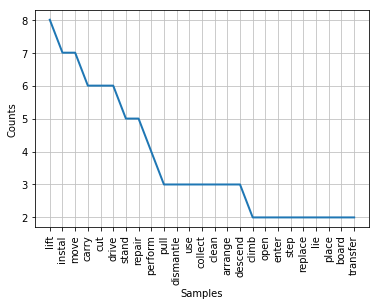

Total count for this dataset is 138


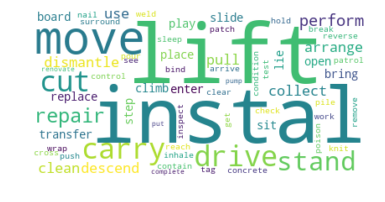



Caught in/between Objects


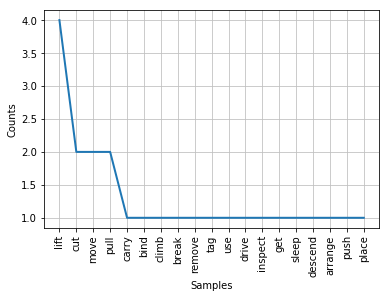

Total count for this category is 25


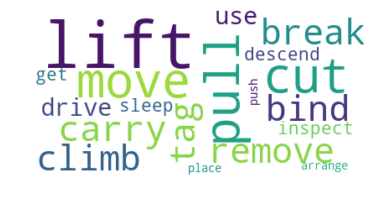

Top 5 activity word and their sentences


lift
====

lift the lifting tray
lifting lug
lifting works using Overhead Travelling Crane
lifting a Concrete Pile Head



cut
===

cutting down trees
cutting the trees



move
====

removing the glass door
moving brick trucks
moving downwards



pull
====

pulling out cages
pulling out the cages



carry
=====

carrying the job of binding Reinforcement Steel Cage


Falls


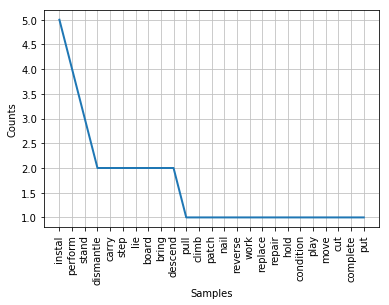

Total count for this category is 42


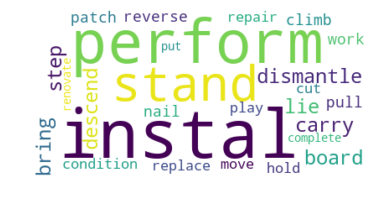

Top 5 activity word and their sentences


instal

installing roof trusses
installing the wall cladding
installing the roof
installing air conditioning pipes
installing water cooling cables



perform

performing cable pulling job
performing floor tiles installation
performing the installation of the working platform
performing the installation



stand
=====

standing on plywood plate
standing on the scaffolds
standing on a wagon



dismantle

dismantling Shear Wall
dismantling the scaffolding



carry
=====

carrying mold installation
carry out binding
carrying out T-Beam


Drowning


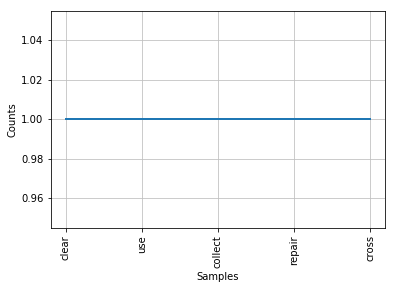

Total count for this category is 5


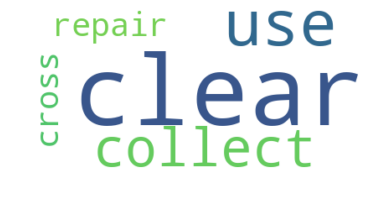

Top 5 activity word and their sentences


clear
=====

clearing work using bulldozer



use
===




collect

collecting water samples



repair

repairing a sand processing machine



cross
=====

crossing the river


Other


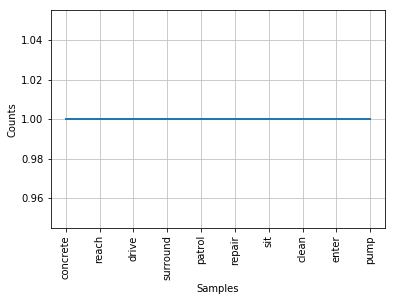

Total count for this category is 10


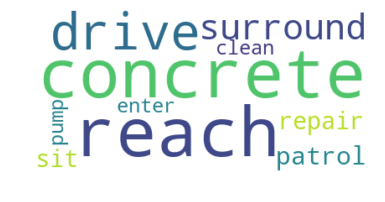

Top 5 activity word and their sentences


concrete

concreting the floor



reach
=====

reaching the control room



drive
=====

driving down a steep path



surround

surrounding earth afterwards



patrol

patroling the plantation


Struck By Moving Objects


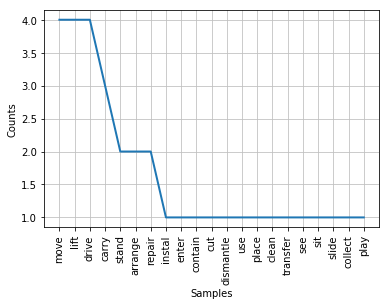

Total count for this category is 35


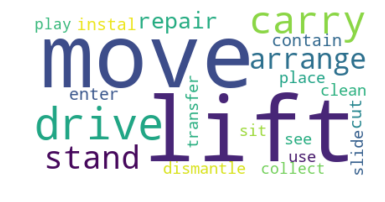

Top 5 activity word and their sentences


move
====

move the box containing foods
moving forklift
moving truck
moving the logs



lift
====

lifting a bundle
lifting a pile
lifting the drain block
lifting a load



drive
=====

driving downhill
driving uphill
driving up the steep road
driving a tractor
driving a tractor carrying earth



carry
=====

carrying road leveling work using steamroller
carrying out visual inspection



stand
=====

standing on the drawbar trailer
standing on the connection


Collapse of object


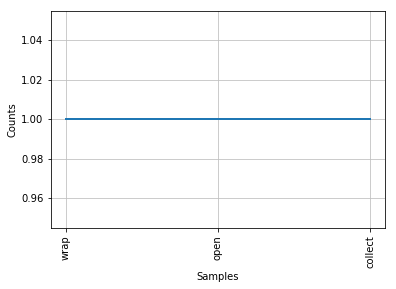

Total count for this category is 3


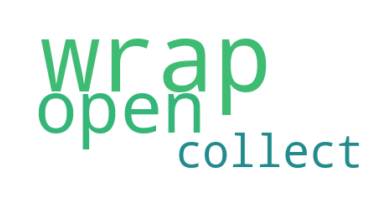

Top 5 activity word and their sentences


wrap
====

wrapping plastic tubing



open
====

opening the mold



collect

collecting cans


Fires and Explosion


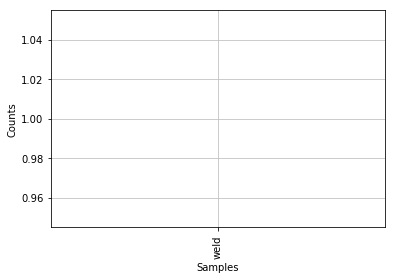

Total count for this category is 1


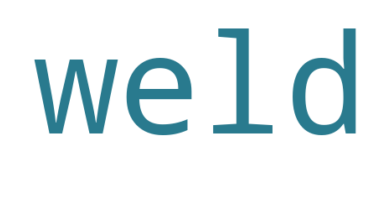

Top 5 activity word and their sentences


weld
====

welding the cover


Electrocution


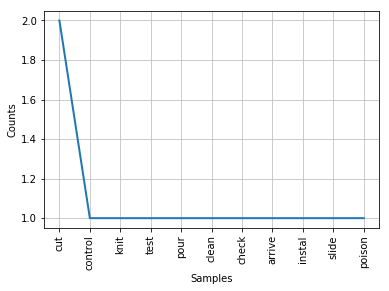

Total count for this category is 12


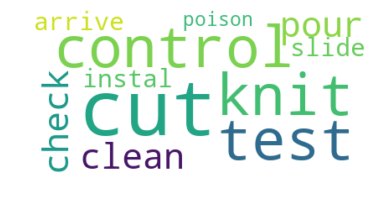

Top 5 activity word and their sentences


cut
===

cutting the oil palm fruit
cutting a cable



control

controlling the traffic



knit
====

knitting the oil palm fruits



test
====

testing the circuit



pour
====

pouring the concrete


Suffocation


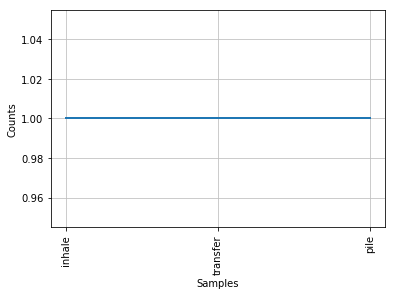

Total count for this category is 3


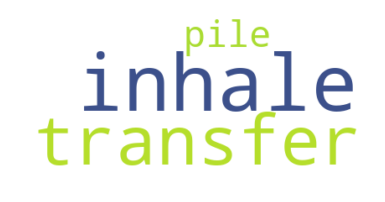

Top 5 activity word and their sentences


inhale

inhaling toxic gas while transfering schedule wastes



transfer




pile
====

piling machine


Exposure to Chemical Substances


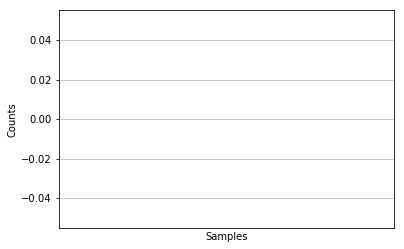

Total count for this category is 0


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [267]:
if ProcessMsiaDataSet:
    msia_verb_count = 0
    msia_chunk_count = 0
    VisualisationAll(MsiaCaseItems)
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    msia_chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                msia_verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(msia_chunk_count))
    print("Msia Extraction Verb Count is " +  str(msia_verb_count)) 
    with open('summary.csv','a') as file:            
        file.write("Msia Total" + "," + str(msia_verb_count) + '\n')    

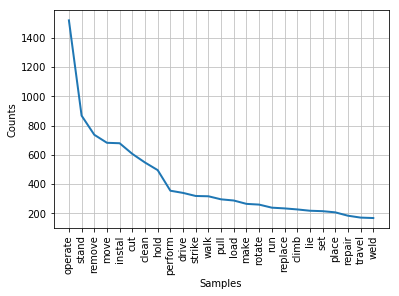

Total count for this dataset is 28260


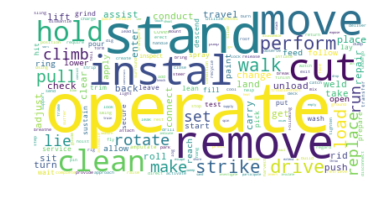



Caught in/between Objects


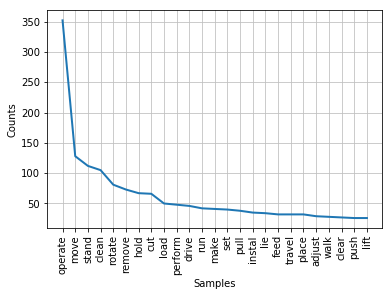

Total count for this category is 3764


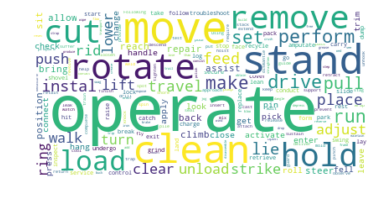

Top 5 activity word and their sentences


operate

operating a rough terrain forklift
operating an asphalt-pulverizing machine
operating a polypropylene filament extruder machine
operating the backhoe
operating a Lavina
operating an unfamiliar stand-up forklift
operating an E30 XL Hyster
operating a scissor lift
operating an aerial lift
operating a CNC lathe



move
====

moving boom section
removing the fifth beam
moving rough-top conveyor
moving tire
moving conveyor belt
moving conveyor belt
moving conveyor
removing safety brackets
moving the boom
moving rollers



stand
=====

standing on a portable ladder adjusting
standing platform
standing in front
standing near the tunnel entrance
standing in the basket
standing at the rear
standing at the front
standing in front
standing in front
standing on the pipe



clean
=====

cleaning photo sensor eyes
cleaning the build-up
cleaning the machine
cleaning the rag
cleaning the idler roll
cleaning rollers
cleaning a plastic grinding machine


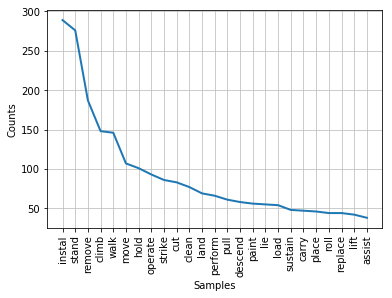

Total count for this category is 5692


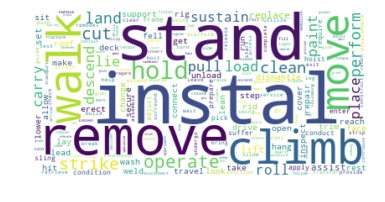

Top 5 activity word and their sentences


instal

installing vinyl sidings
installing roofing felt paper
installing Western Union Signs
installing an advertisement sign
installing the advertisement
installing curbing for the installation
installing fasteners
installing reinforcing bars
installing rigging equipment
install the rolled poly plastic over the existing plastic



stand
=====

standing an A-frame ladder
standing on the corner end
standing on a beam
standing on the skylight
standing atop a rice bin
standing in the bin
standing on unguarded ladder
standing on a FMC Commander
standing on the flatbed trailer
standing on gondola roofs



remove

remove a piece of roofing machinery
removing road construction warning signs
removing a number
removing wall-mounted triangular brackets
removing the almonds
removing a cover
removing flue gas tubes
removing tin roof panels
removing the ladder
removing asbestos containing material



climb
=====

climbing rope
climbing pegs
climbing tower


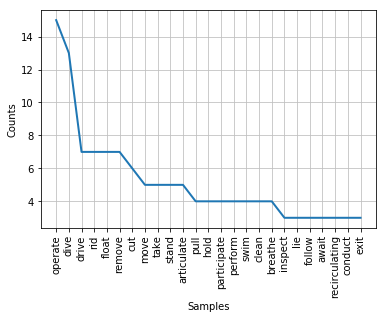

Total count for this category is 283


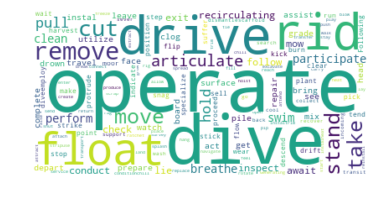

Top 5 activity word and their sentences


operate

operating a Link-Belt Crane
operating the Model Number D9H bulldozer
operating a D-9 dozer stock piling gravel
operating a John Deere Model Number200C LC excavator
operating the machine
operating a backhoe
operating a Yamaha BearTracker all-terrain vehicle
operating a Komatsu PC
operating a backhoe loader
operating a Ford



dive
====

diving operations
diving for sea urchins
diving equipment
diving partner/trainer
diving for sea urchins
diving employing a Huka device
diving equipment
diving helmet
diving helmet
diving underneath a casino barge



drive
=====

driving a John Deere tractor
driving a Kubota Model Number MX500
driving the tractor
driving under adverse weather conditions
driving on the road
driving the backhoe
driving on a dirt road



rid
===

riding a tractor John Deere Tractor
riding lawn mower
riding in a company vehicle
riding in a dump truck
riding lawn mower



float
=====

floating in the water
floating face
floati

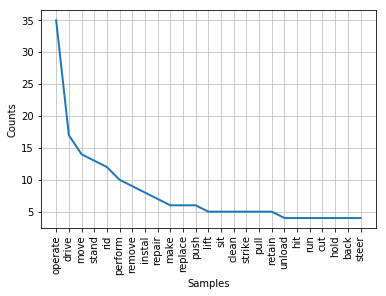

Total count for this category is 422


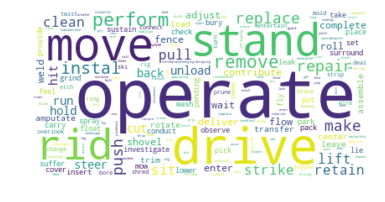

Top 5 activity word and their sentences


operate

operating a standup forklift
operating a backhoe
operating an electric forklift
operating a bobcat loader
operating an industrial truck
operating a box temper furnace
operating at the bottom
operating a rough terrain forklift
operating a 40-ton Lorain crane
operating other scissor lifts



drive
=====

driving the lift
driving a forklift
driving a vehicle
driving Employee
driving the lift
driving a REDI-LIFT Hydraulic truck crane
driving the aerial lift truck
driving the ATV
driving a Terex
driving a Toyota sit



move
====

moving pistons
moving a two-wheeled Kelco blasting pot
removing a hose
moving the cart
removing the nut
removing the wood material
moving the line
removing the defective component Employee
removing chains
removing a screw-on end cap nitrogen



stand
=====

standing on the skid
standing on the ground
standing on the side of the cooling table
standing position
standing near the end
standing on a stick
standing in fr

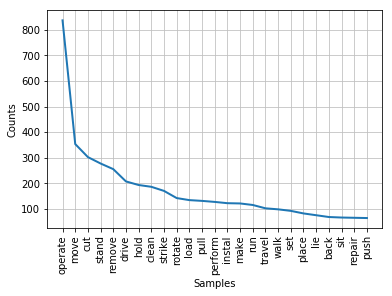

Total count for this category is 11075


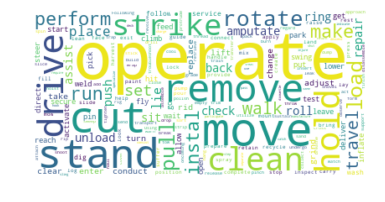

Top 5 activity word and their sentences


operate

operating a beet harvesting machine
operating a wire rope winding machine
operating the wire rope winder without wearing face protection
operating an Oakley
operating a Golf
operate a sandblasting pot
operating above the revolutions-per-minute
operating a Raymond Model Number
operating pallet jacks
operating an aerial lift



move
====

moving cans
moving components
remove the welding splatter
removing jet fuel emissions
removing an item
moving the cart
removing an air hose
move out of the way of the falling branch
removing mechanical equipment
moving part



cut
===

cutting the seal
cutting a third piece
cutting an aluminum sheet
cutting a metal railing
cutting through a knot
cutting torch
cutting down a eucalyptus tree
cutting the top
cutting the beam
cutting a piece



stand
=====

standing in front
standing in the front
standing in front
standing on the elevated lift platform
standing by a tree
standing near the handler
standing i

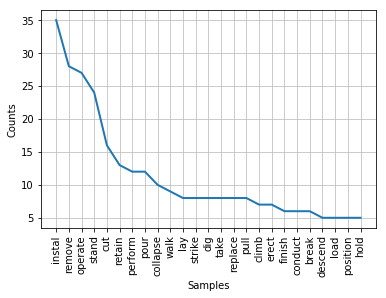

Total count for this category is 716


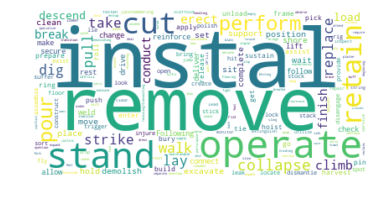

Top 5 activity word and their sentences


instal

installing the first stage
installing the advertising display
installing equipment
installing control
installing purlins
installing steel
installing a concrete form
installing the wall
installing guardrails
installing the last section



remove

removing branch cuttings
removing the old tile
removing old adhesive
removing the roof
removing a temporary wall
removing the top track
removing steel roofing panels
removing roof panel
removing the panel
removing a transmission



operate

operating the forklift
operating the forklift
operating an Eagle
operating a bull float
operating a backhoe
operating a front loader
operating a band saw
operating a skid-steer tractor
operating a Fraco
operating a VERSACRANE Model Number TC36000 crane



stand
=====

standing on an epoxy-coated dowel
standing on an extension ladder
standing on the front
standing on this section
standing on the roof
standing on a 1-inch by 4-inch catwalk
standing on top
stand

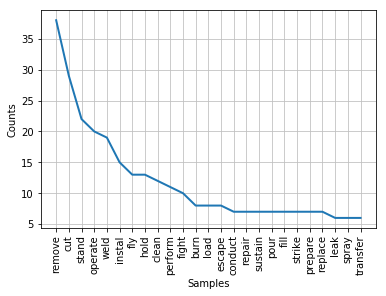

Total count for this category is 776


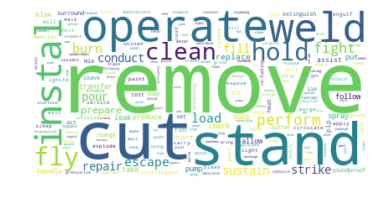

Top 5 activity word and their sentences


remove

removing a custom
removing rock gravel
removing the pipe stem
removing the nozzle
removing Accelerator P
removing the flange
removing the mill access doors
removing the door
removing the kinks
removing cores



cut
===

cutting torch
cutting grinding
cutting area
cutting area
cutting torch
cutting the device with a cutting torch
cutting torch
cutting torch
cutting torch
cutting torch



stand
=====

standing in an excavation
standing in the immediate area
standing on a platform
standing with the upper portion
standing at the rear
standing at the top
standing on the top edge
standing on planks
standing on the fourth floor landing
standing near the door



operate

operating a Maren model
operating the air valve
operating the choke
operating a vacuum truck
operating procedures
operating a blender
operating presses
operating the electronic firing
operating a gasoline
operating a ditching machine



weld
====

welding a shaft
welding torch


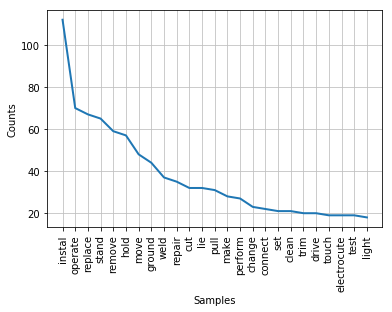

Total count for this category is 2272


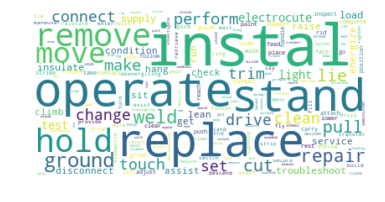

Top 5 activity word and their sentences


instal

installing a new light fixture
install metal sub-flooring
installing all dielectric self-supporting fiber-optic cable
installing additional cross braces
installing supporting braces
installing a thermostat line
installing a central air conditioner
installing an electric pole
installing an air conditioning unit
installing equipment



operate

operating the sandblasting equipment
operating a Bliss OBI
operating an asphalt roller
operating the asphalt roller
operating a Bobcat
operating an overhead crane
operating a tug
operating a pile driver
operating a soil auger
operating the auger



replace

replacing the rubber gasket
replacing the guide
replacing some poles
replacing the cover
replacing the ends
replacing light bulbs
replacing the ballast
replacing a ballast
replacing a ballast
replacing a power breaker cover



stand
=====

standing at the end
standing behind Employee
standing on a metal ventilation duct
standing on the shoulder


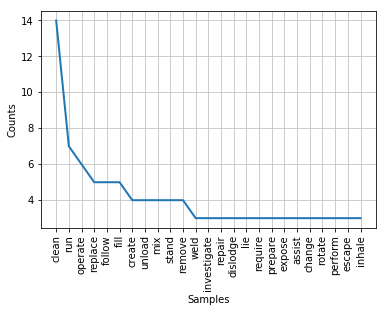

Total count for this category is 266


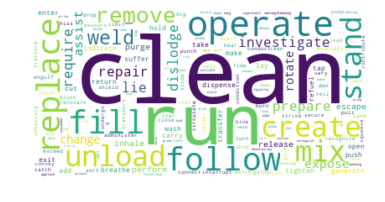

Top 5 activity word and their sentences


clean
=====

cleaning the HVAC system
cleaning up the leaking oil
cleaning up the leaking oil
cleaning equipment
cleaning dust
cleaning the Liebert air conditioning units
cleaning up from the evening meal
cleaning technician
cleaning tech
cleaning up the spill



run
===

running for cover
running water
running water
running off the sides
running on the mill
running polyvinyl chloride
running a piece



operate

operating gas forklifts
operating the main control device handles
operating each mixer
operating extruding
operating specifications
operating a LYCOFIT Model Number
operating a Caterpillar D-8 bulldozer
operating a manual choke
operating a Vac-U-Vator vaculator



replace

replacing a solenoid valve
replacing a valve
replacing empty EtO cylinders
replacing a sump pump
replacing an inoperative valve



follow

following the hose
following the maintenance activities
following an examination
following confined space procedures


Exposure t

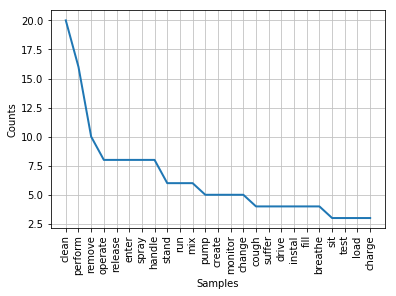

Total count for this category is 440


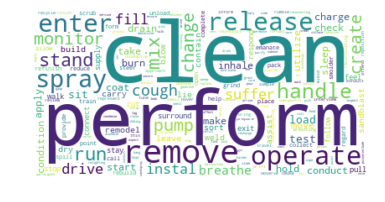

Top 5 activity word and their sentences


clean
=====

cleaning fluids
cleaning the floors
cleaning concrete
cleaning employee
cleaning the butcher block area
cleaning up a stadium
cleaning supplies
cleaning the lavatories
cleaning chemical
cleaning chemicals



perform

performing a fire watch
performing all maintenance
performing fluoride tests
performing mold inspections
performing routine maintenance
perform any monitoring
performing janitorial duties
performing the necessary steps
performing a routine task
performing a chemical transfer



remove

removing pool paint
remove the old coating
removing the hose
removing an I-beam
removing paint
removing a resin pin
removing liquid trichloroethylene
remove a cleaning system
removing stains
removing carpet



operate

operating industrial trucks
operating in the warehouse
operating this gasoline
operating manual specifies operating limits
operating a tanker truck
operating in the enclosed garage
operating a paper coating machine
operati

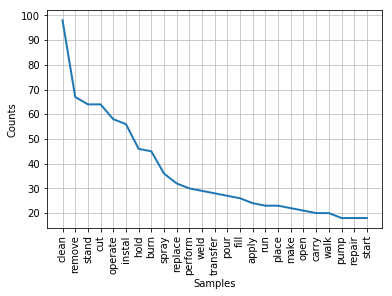

Total count for this category is 2554


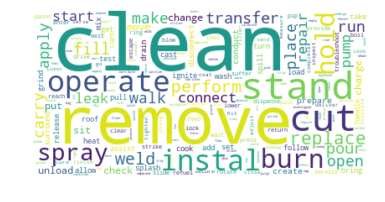

Top 5 activity word and their sentences


clean
=====

cleaning the interior
cleaning gypsum
cleaning the interior
cleaning the tank Employee
cleaning with acetone
cleaning a separation tank
cleaning with a rag
cleaning out metal shavings
cleaning ground aluminum particles
cleaning miscellaneous material



remove

removing material
removing rubber hoses
removing a bearing
removing the filter canisters
removing a manufactured part
removing locking pins
removing a temporary electric service
removing racks
removing the second main fuse
removing the pump



stand
=====

standing in front
standing by the suction valve
standing by the side
standing on south side
standing north
standing near the unit
standing at the base
standing on the ground
standing near the rear driver
standing outside the hopper



cut
===

cutting a pipe
cutting the well
cutting the well casing
cutting torch
cutting torch
cutting tip
cut a hole into an existing injection
cutting an empty VMP Naphtha drum
cutting torch


In [255]:
if ProcessOshaDataSet:
    osha_chunk_count = 0
    osha_verb_count = 0
    VisualisationAll(OshaCaseItems)
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    osha_chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                osha_verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(osha_chunk_count))
    print("Osha Extraction Verb Count is " +  str(osha_verb_count)) 
    with open('summary.csv','a') as file:            
        file.write("Osha Total" + "," + str(osha_verb_count) + '\n')

# Output to excel file with new additional columns for activity and activity chunks

In [268]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',MsiaCasesDF)

In [ ]:
#Write to excel with the additional columns for activity verb
if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)

# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- For Msia dataset there's only 240 records, so we have a rather small dataset for training. Also, Msia dataset only have Summary column whereas Osha has a more detailed Descrition column.

- For Osha, we were able to extract out 28260 activities. This could mean for each column more than 1 activity (most likely a series of activity) taking place prior to the accident since total records in the dataset is 16003.

- In some sentences, for example, the actually activity is "handling maintenance work", thus the actual activity is maintenance work but because the regular expression parser is designed to extract the verb activity resulted in "handling" being captured instead of "maintaining" and results in a less than accurate description of the activity extracted from the dataset.

- Further improvements: Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.